In [1]:
"""import kagglehub
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Download latest version
path = kagglehub.dataset_download("inancigdem/eeg-data-for-mental-attention-state-detection")

print("Path to dataset files:", path)

# Collect all file names
file_names = [] 
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        file_names.append(os.path.join(dirname, filename))"""

'import kagglehub\nfrom scipy.io import loadmat\nimport os\nimport matplotlib.pyplot as plt\nimport pandas as pd\nimport numpy as np\n\n# Download latest version\npath = kagglehub.dataset_download("inancigdem/eeg-data-for-mental-attention-state-detection")\n\nprint("Path to dataset files:", path)\n\n# Collect all file names\nfile_names = [] \nfor dirname, _, filenames in os.walk(path):\n    for filename in filenames:\n        file_names.append(os.path.join(dirname, filename))'

# Load data

In [2]:
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch
import mne
from mne.preprocessing import ICA

In [3]:
path = 'C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/EEG Data'

# Collect all file names
file_names = []
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('.mat'):
            file_names.append(os.path.join(dirname, filename))
        
# Sắp xếp file theo số thứ tự (để đảm bảo đúng thứ tự subject)
file_names.sort(key=lambda x: int(x.split('eeg_record')[-1].split('.mat')[0]))

In [4]:
sampFreq = 128
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

In [5]:
# Hàm đọc dữ liệu 
def load_data(file_name):
    mat = loadmat(file_name)

    # Trích xuất dữ liệu từ đối tượng 'o'
    mdata = mat['o']
    sampFreq = int(mdata['sampFreq'][0][0][0][0])  # Tần số lấy mẫu
    data = mdata['data'][0, 0]  # Dữ liệu đầy đủ

    # Lấy tín hiệu từ các kênh 4–17
    eeg_data = data[:, 3:17]

    return data, eeg_data

In [6]:
def load_eeg_data(file_names):
    all_data = []
    for file_name in file_names:
        # Lấy Trial ID từ tên file
        trial_id = int(file_name.split('eeg_record')[-1].split('.mat')[0])

        try:
            print(f"Đang xử lý file: {file_name}, Trial ID: {trial_id}")
            _, eeg_data = load_data(file_name)

            # Kiểm tra kích thước dữ liệu trả về
            if eeg_data is not None and eeg_data.size > 0:
                all_data.append((eeg_data))
            else:
                print(f"Dữ liệu EEG từ file {file_name} không hợp lệ hoặc rỗng.")
        except Exception as e:
            print(f"Lỗi khi xử lý file {file_name}: {e}")
    
    return all_data

In [7]:
def get_data_5days(full_data):
    num_initial_days=2

    filtered_data_5days = []

    for i in range(5):  # 5 người
        # Số lượng file của mỗi người, người thứ 5 có 6 file, còn lại là 7 file
        num_files = 7 if i != 4 else 6

        # Lấy dữ liệu từ các ngày đo thực sự (bỏ qua 2 ngày đầu)
        real_measurement_files = full_data[i * 7 + num_initial_days: i * 7 + num_files]

        # Thêm dữ liệu vào danh sách kết quả
        filtered_data_5days.extend(real_measurement_files)

    return filtered_data_5days

In [8]:
full_data = load_eeg_data(file_names)
reduce_data_5days = get_data_5days(full_data)

Đang xử lý file: C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/EEG Data\eeg_record1.mat, Trial ID: 1
Đang xử lý file: C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/EEG Data\eeg_record2.mat, Trial ID: 2
Đang xử lý file: C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/EEG Data\eeg_record3.mat, Trial ID: 3
Đang xử lý file: C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/EEG Data\eeg_record4.mat, Trial ID: 4
Đang xử lý file: C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/EEG Data\eeg_record5.mat, Trial ID: 5
Đang xử lý file: C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-

# Filter data

In [9]:
from scipy.signal import butter, filtfilt, iirnotch

# Hàm tạo bộ lọc thông cao và thông thấp
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Hàm tạo bộ lọc notch
def notch_filter(data, notch_freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    return filtfilt(b, a, data, axis=0)

In [10]:
def filter_data(data_set):
    # Lọc thông cao và thông thấp và lọc notch cho từng file
    filtered_all_data = []
    for data_eeg in data_set:
        # Lọc thông cao và thông thấp cho dữ liệu của file hiện tại
        lowcut = 0.5  # Hz
        highcut = 30  # Hz
        filtered_data_bandpass = bandpass_filter(data_eeg, lowcut, highcut, sampFreq)

        # Lọc notch để loại bỏ nhiễu 50 Hz cho dữ liệu đã lọc thông
        notch_freq = 50  # Hz
        filtered_data_notch = notch_filter(filtered_data_bandpass, notch_freq, sampFreq)

        # Lưu dữ liệu đã lọc vào danh sách
        filtered_all_data.append(filtered_data_notch)
    
    return filtered_all_data

In [11]:
filtered_full_data = filter_data(full_data)
filtered_reduce_data = get_data_5days(filtered_full_data)

In [12]:
def plot_all_channels(eeg_data_list, channel_names, title="EEG Signals for All Channels"):

    num_channels = len(channel_names)
    time_range = range(5000, 15000)

    fig, ax = plt.subplots(num_channels, 1)
    fig.set_figwidth(20)
    fig.set_figheight(50)

    for i in range(num_channels):
        combined_data = []
        for eeg_data in eeg_data_list:
            combined_data.extend(eeg_data[time_range, i])
        combined_data = np.array(combined_data)
        data_ave = combined_data - np.mean(combined_data)
        ax[i].plot(data_ave)
        ax[i].set_title(channel_names[i])
        ax[i].set_ylim(-100, 100)

    plt.tight_layout()
    plt.show()


In [13]:
# 'F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4'

# AF3 FC5 T7 T8 FC6 F4 F8 
# 4 5 8 9 10 11 16

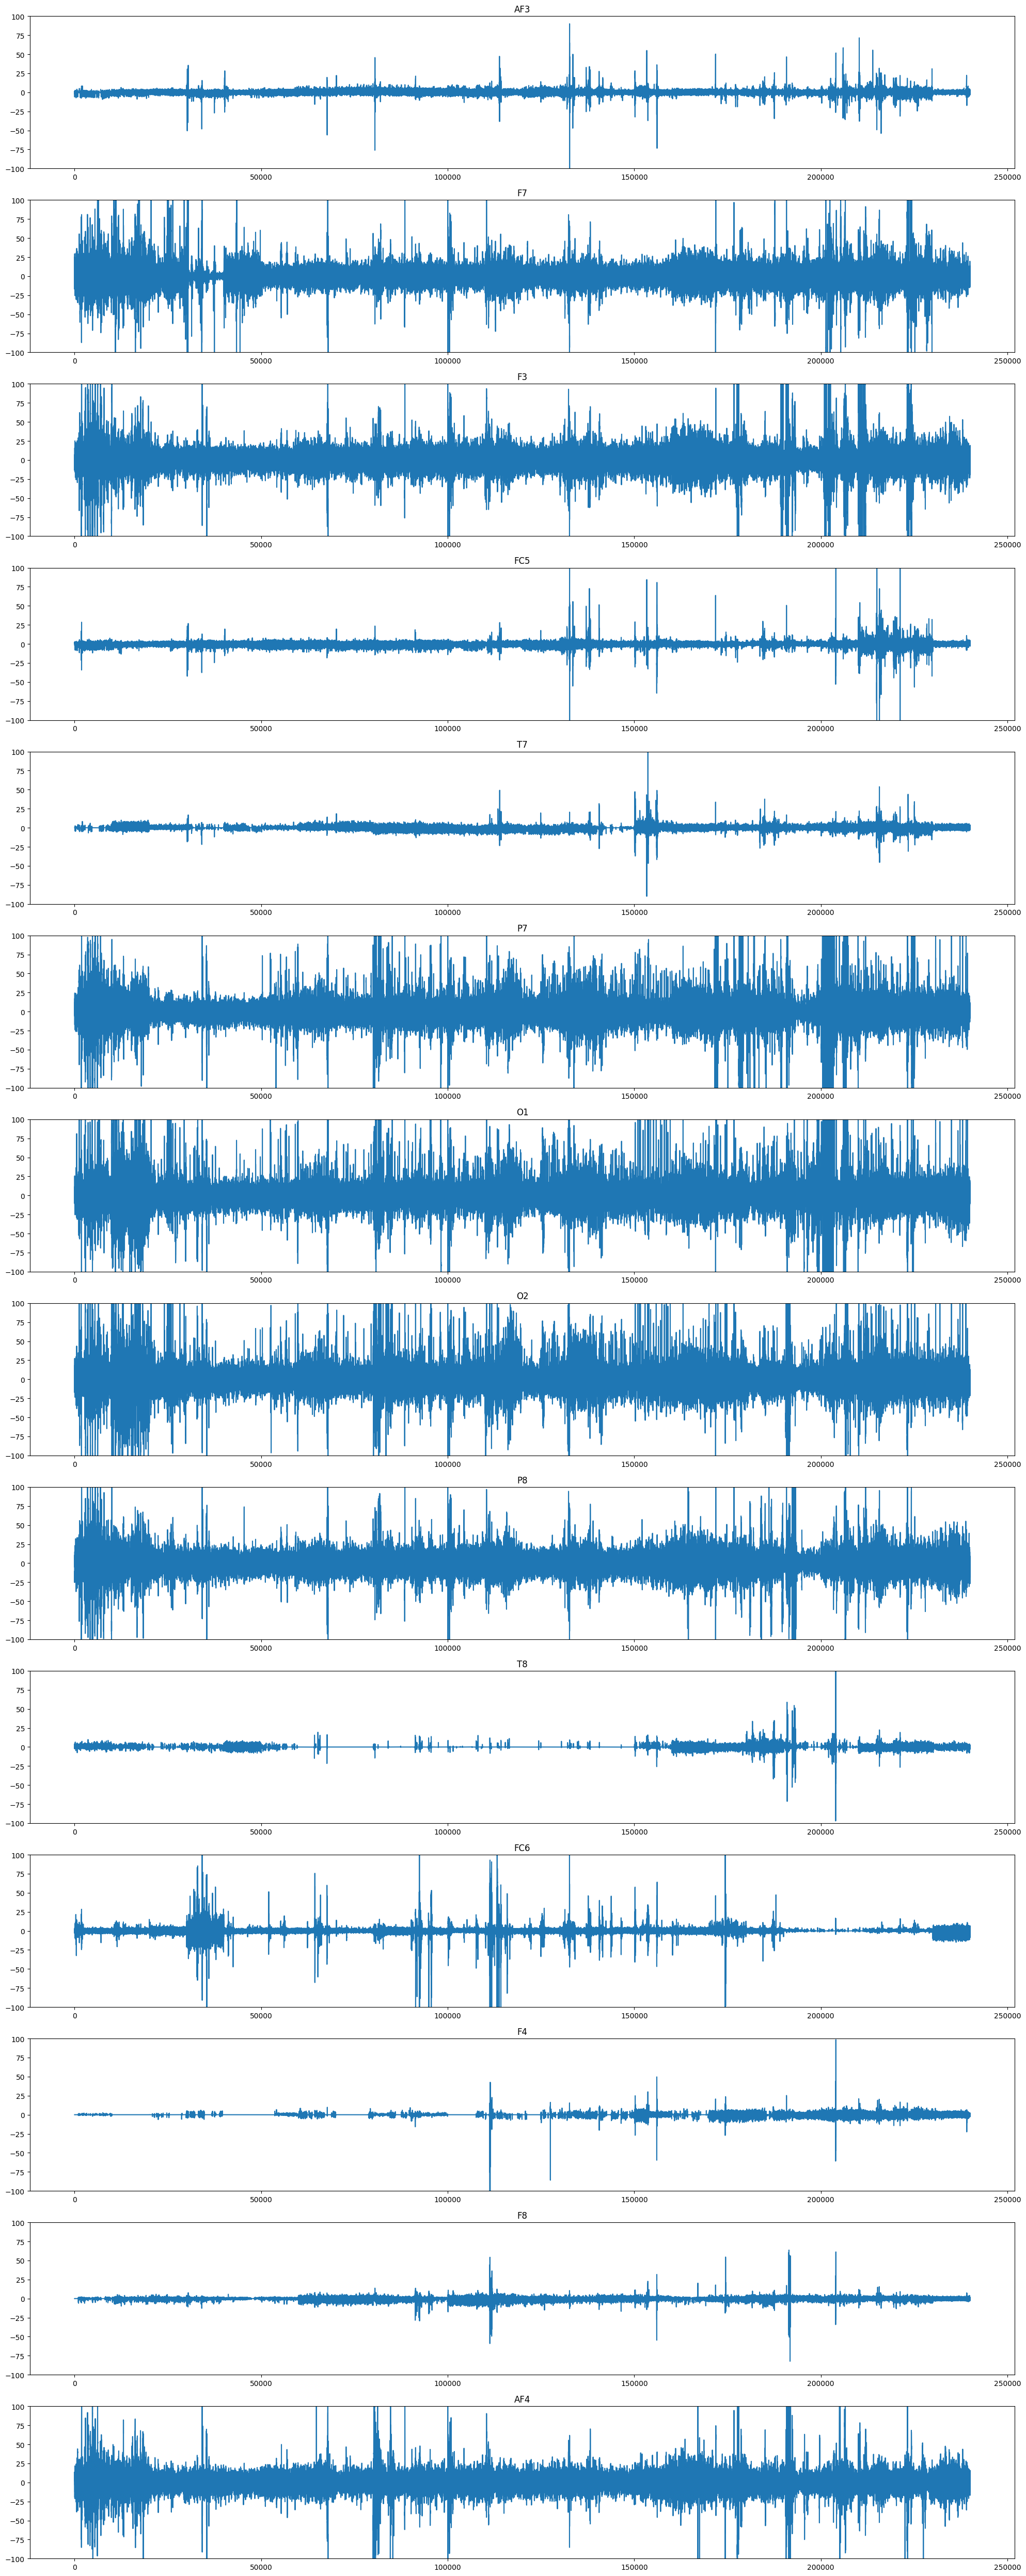

In [14]:
plot_all_channels(filtered_reduce_data, channel_names)

In [15]:
# 'F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4'
useful_channels=[1,2,5,6,7,8,13]
useful_channels_names=['F7','F3','P7','O1','O2','P8','AF4']

filtered_full_data_7channel = [eeg_data[:, useful_channels] for eeg_data in filtered_full_data]
filtered_reduce_data_7channel = get_data_5days(filtered_full_data_7channel)

* Visualize data

In [16]:
def analyze_data(filtered_all_data, file_names, subject_map=None, num_files=2):
    # Phân tích dữ liệu
    if subject_map is not None:
        # Chỉ phân tích những file có trong subject_map
        valid_indices = sum(subject_map.values(), [])
        valid_indices = [x - 1 for x in valid_indices]
    else:
        # Phân tích tất cả các file
        valid_indices = list(range(len(file_names)))

    for i in valid_indices[:num_files]:  # Duyệt qua một số file để trực quan hóa
        data, eeg_data = load_data(file_names[i])

        # Vẽ dữ liệu đầy đủ từ file
        print('Dữ liệu đầy đủ từ file {}:'.format(file_names[i]), data.shape)
        plt.figure(figsize=(10, 4))
        plt.plot(data)
        plt.title(f'Dữ liệu đầy đủ từ File {i + 1}')
        plt.xlabel('Samples')
        plt.ylabel('EEG Signal Amplitude')
        plt.show()

        # Vẽ dữ liệu từ các kênh 4-17
        print('\nDữ liệu EEG từ các kênh 4-17:', eeg_data.shape)
        plt.figure(figsize=(10, 4))
        plt.plot(eeg_data[:1000, :])  # Giả sử vẽ 1000 mẫu đầu tiên
        plt.title('Data EEG (Channel 4-17) from 1000 data')
        plt.xlabel('Samples')
        plt.ylabel('EEG Signal Amplitude')
        plt.show()

        # Biểu diễn tín hiệu sau khi lọc của 1000 data đầu tiên
        filtered_data = filtered_all_data[i]  # Lấy dữ liệu đã lọc của file thứ i
        plt.figure(figsize=(10, 4))
        plt.plot(filtered_data[:1000, :])  # Lấy 1000 mẫu đầu tiên từ dữ liệu đã lọc
        plt.title('EEG Data After Filtering (High-pass, Low-pass, Notch) from 1000 data')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.show()

Dữ liệu đầy đủ từ file C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/EEG Data\eeg_record1.mat: (308868, 25)


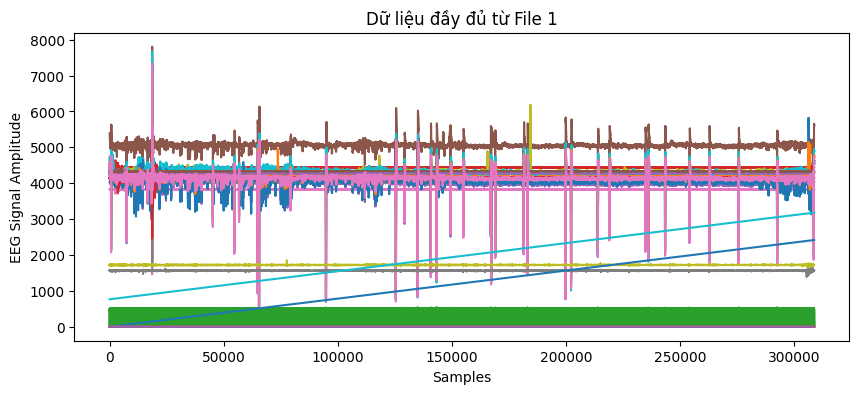


Dữ liệu EEG từ các kênh 4-17: (308868, 14)


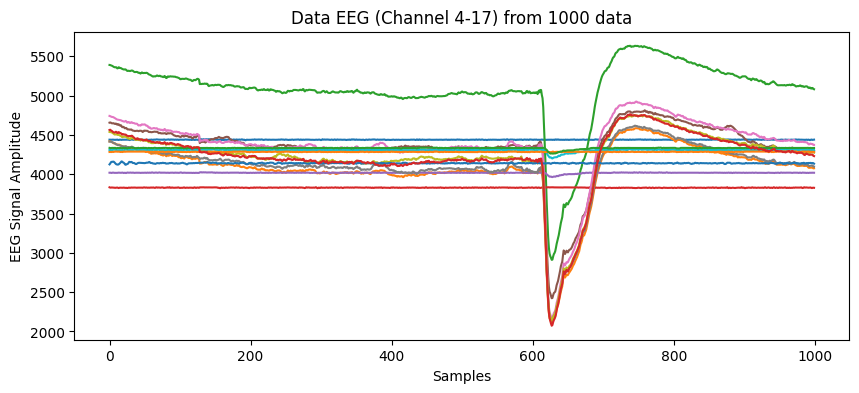

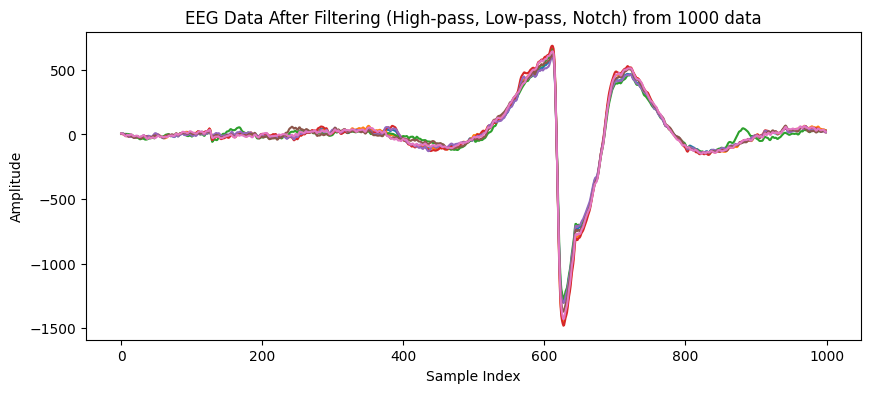

Dữ liệu đầy đủ từ file C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/EEG Data\eeg_record2.mat: (366020, 25)


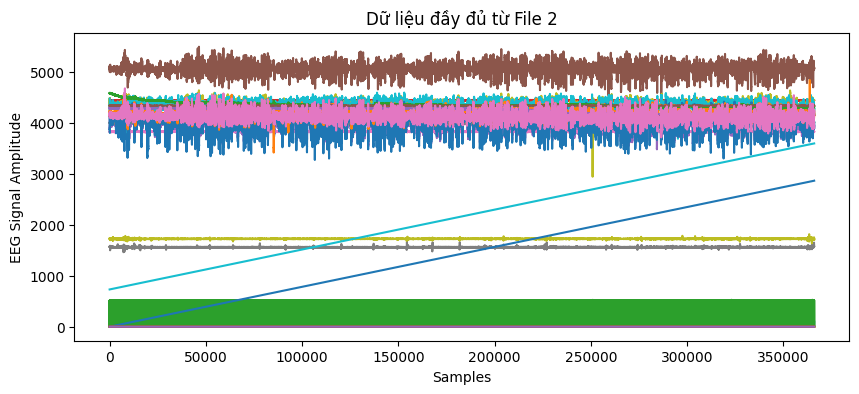


Dữ liệu EEG từ các kênh 4-17: (366020, 14)


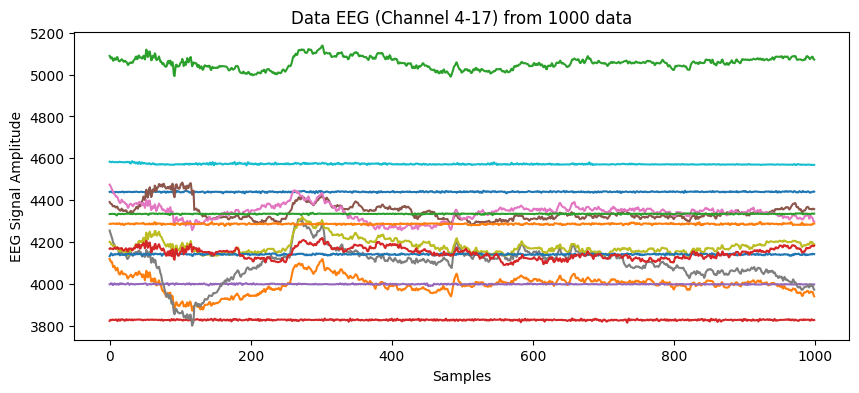

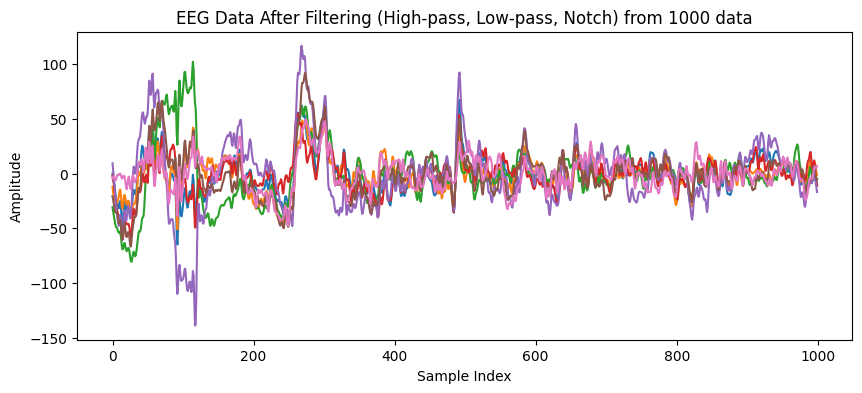

In [17]:
analyze_data(filtered_full_data_7channel, file_names)

In [18]:
# Số tổng subject (5)
total_subjects = 5

# Tạo ánh xạ subject_map, với việc lùi chỉ số
subject_map = {}
for s in range(1, total_subjects + 1):
    # Lùi chỉ số 2 ngày đầu, vì cần bỏ qua 2 ngày thử nghiệm
    a = int(7 * (s - 1)) + 3  # Bắt đầu từ ngày thứ 3
    if s != 5:
        b = a + 5  # Người 1-4 có 5 ngày thực tế
    else:
        b = a + 4  # Người 5 có 4 ngày thực tế
    subject_map[s] = [i for i in range(a, b)]

# In ra subject_map để kiểm tra
print(subject_map)

{1: [3, 4, 5, 6, 7], 2: [10, 11, 12, 13, 14], 3: [17, 18, 19, 20, 21], 4: [24, 25, 26, 27, 28], 5: [31, 32, 33, 34]}


Dữ liệu đầy đủ từ file C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/EEG Data\eeg_record3.mat: (357224, 25)


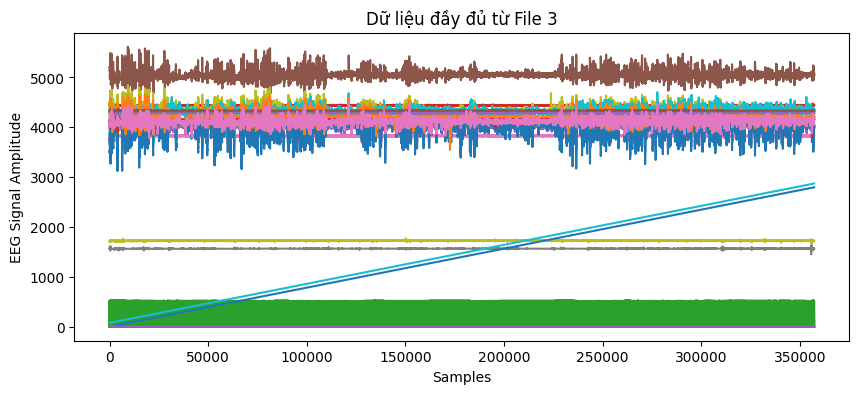


Dữ liệu EEG từ các kênh 4-17: (357224, 14)


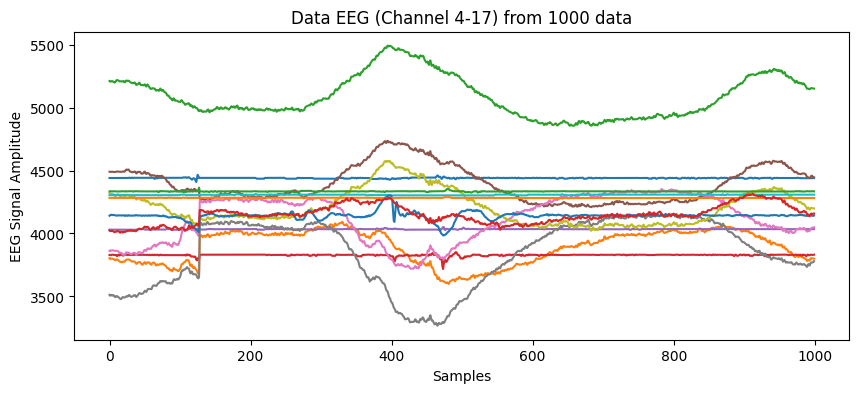

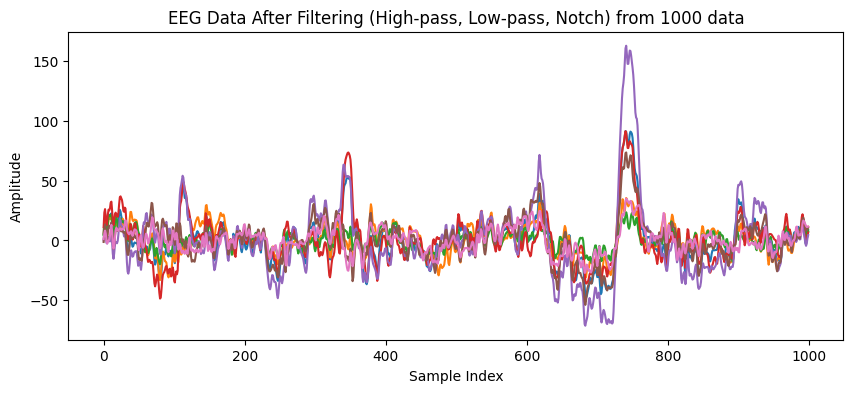

Dữ liệu đầy đủ từ file C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/EEG Data\eeg_record4.mat: (380344, 25)


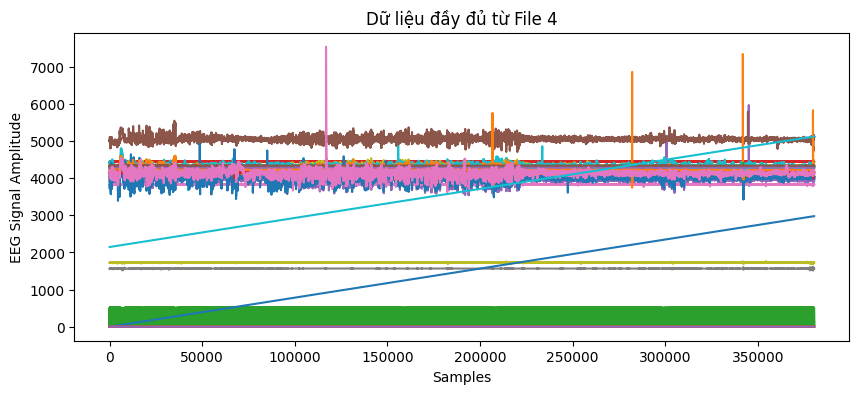


Dữ liệu EEG từ các kênh 4-17: (380344, 14)


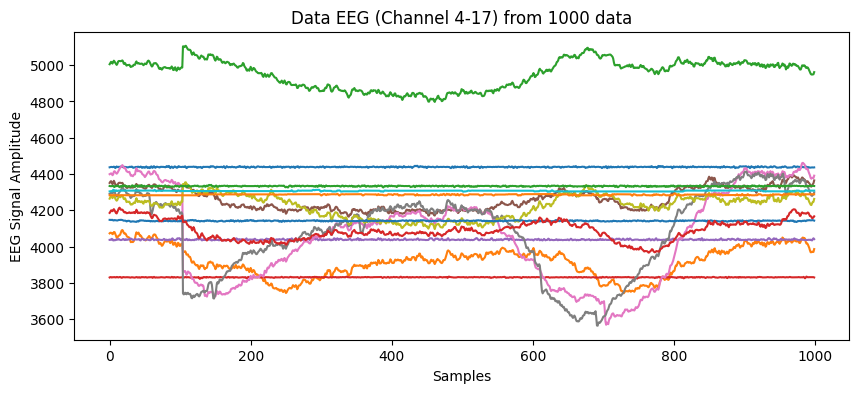

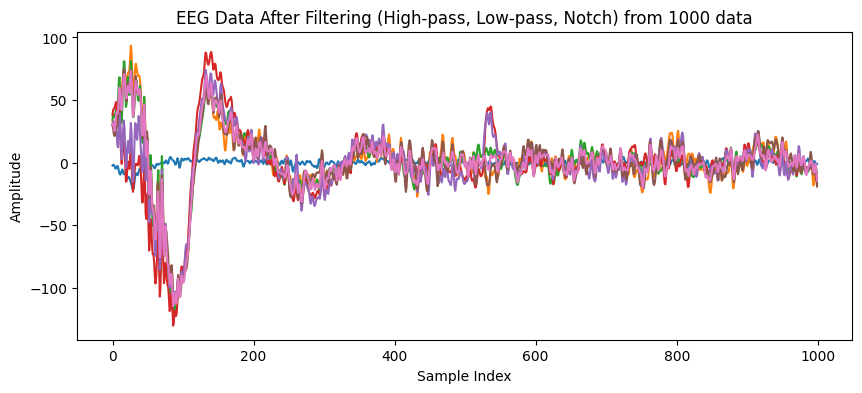

In [19]:
analyze_data(filtered_reduce_data_7channel, file_names, subject_map=subject_map)

In [20]:
def plot_frequency_bands(filtered_data):
    # Định nghĩa các dải tần số
    alpha_low, alpha_high = 8, 13  # Hz
    beta_low, beta_high = 13, 30  # Hz
    delta_low, delta_high = 0.5, 4  # Hz
    theta_low, theta_high = 4, 8  # Hz

    # Lọc thông dải để giữ lại các dải tần số khác nhau
    alpha_band = bandpass_filter(filtered_data, alpha_low, alpha_high, sampFreq)
    beta_band = bandpass_filter(filtered_data, beta_low, beta_high, sampFreq)
    delta_band = bandpass_filter(filtered_data, delta_low, delta_high, sampFreq)
    theta_band = bandpass_filter(filtered_data, theta_low, theta_high, sampFreq)

    # Biểu diễn tín hiệu dải delta
    plt.figure(figsize=(15, 6))
    plt.plot(delta_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
    plt.title('EEG Delta Band (0.5-4 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Biểu diễn tín hiệu dải theta
    plt.figure(figsize=(15, 6))
    plt.plot(theta_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
    plt.title('EEG Theta Band (4-8 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Biểu diễn tín hiệu dải alpha
    plt.figure(figsize=(15, 6))
    plt.plot(alpha_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
    plt.title('EEG Alpha Band (8-13 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Biểu diễn tín hiệu dải beta
    plt.figure(figsize=(15, 6))
    plt.plot(beta_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
    plt.title('EEG Beta Band (13-30 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()


In [21]:
filtered_full_data_7channel[0].shape

(308868, 7)

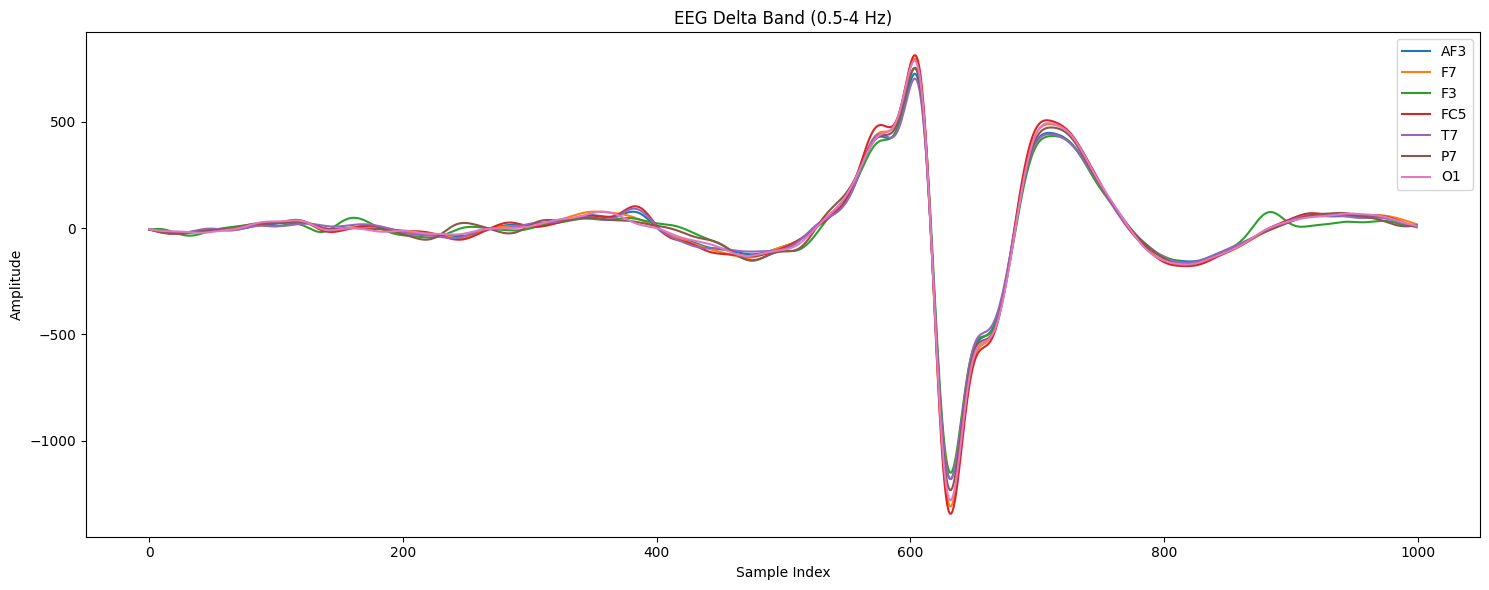

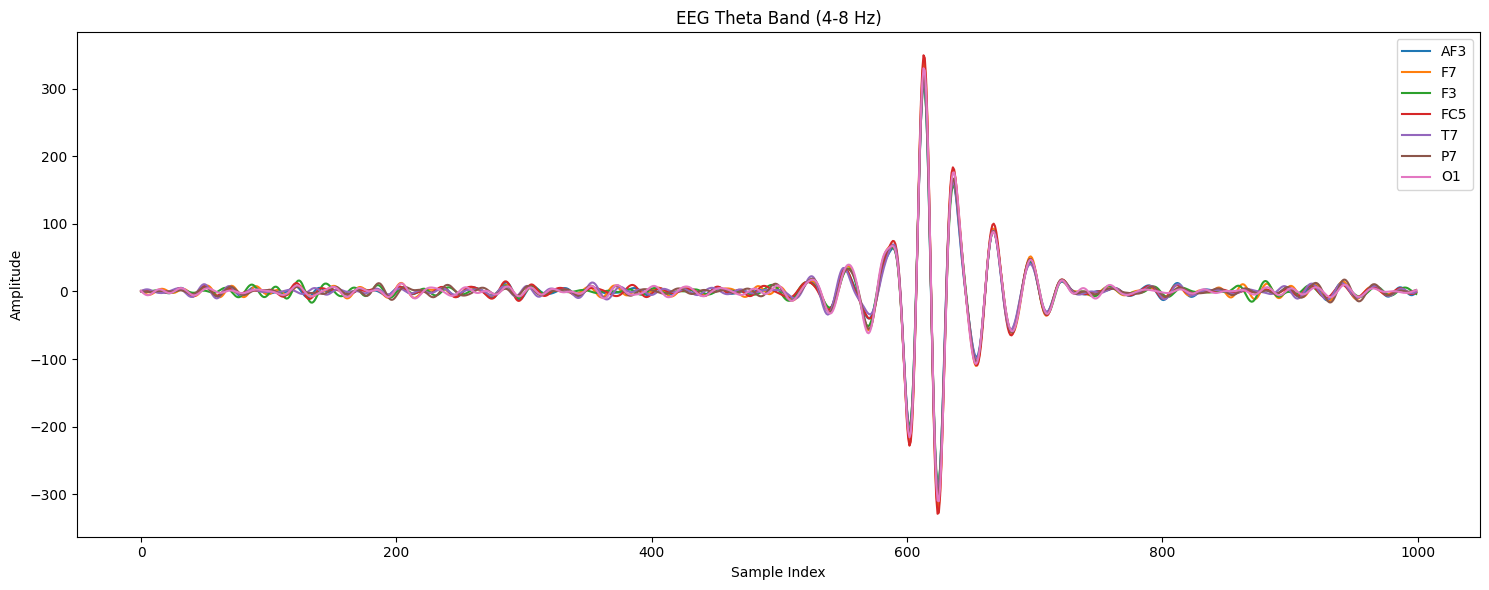

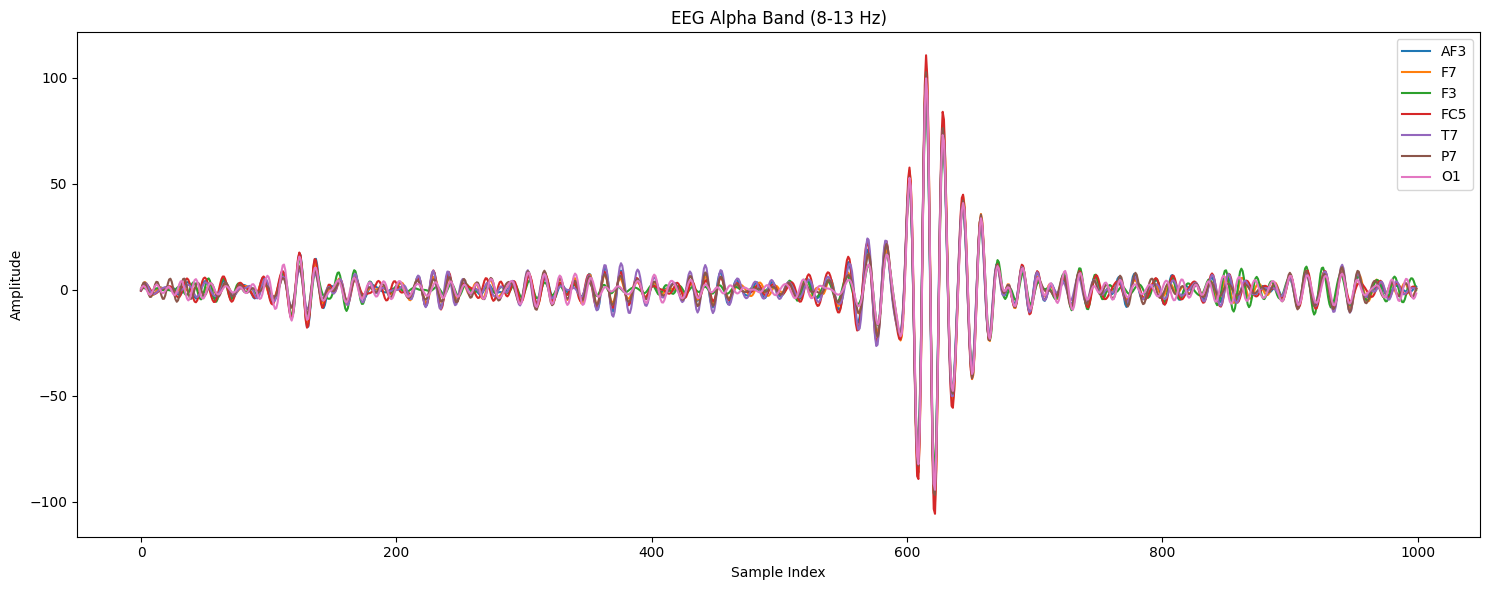

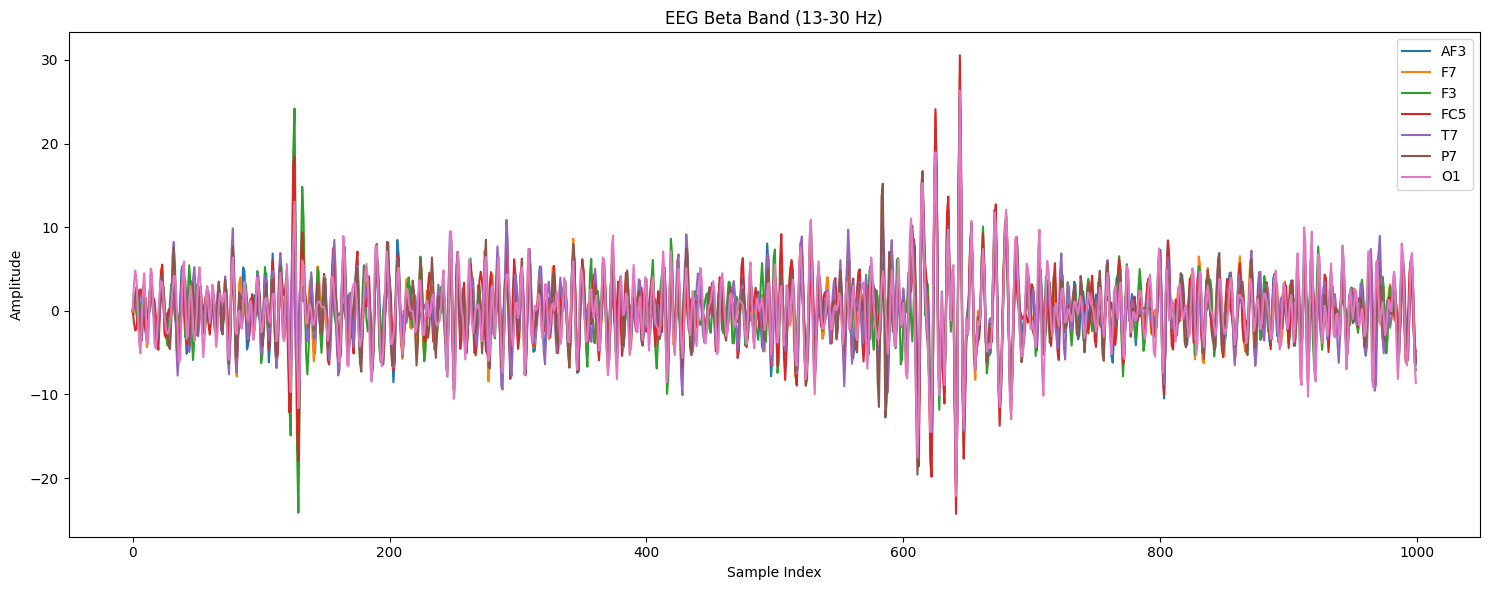

In [22]:
plot_frequency_bands(filtered_full_data_7channel[0])

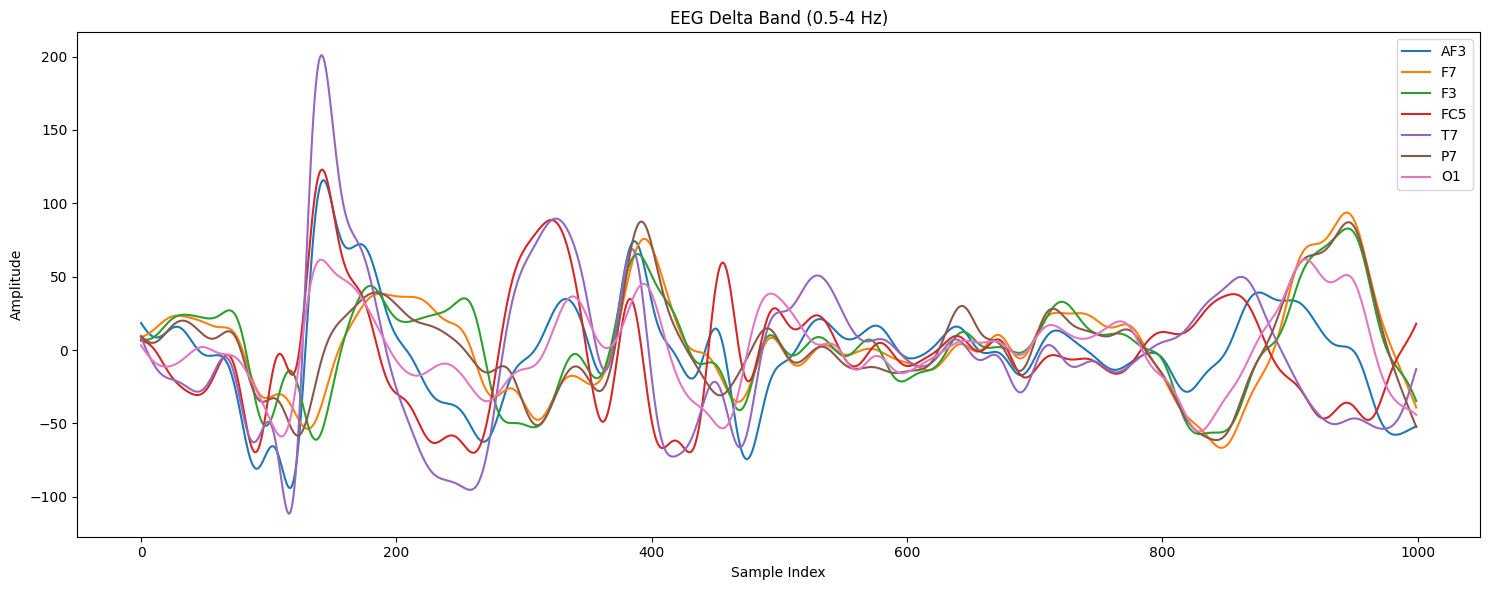

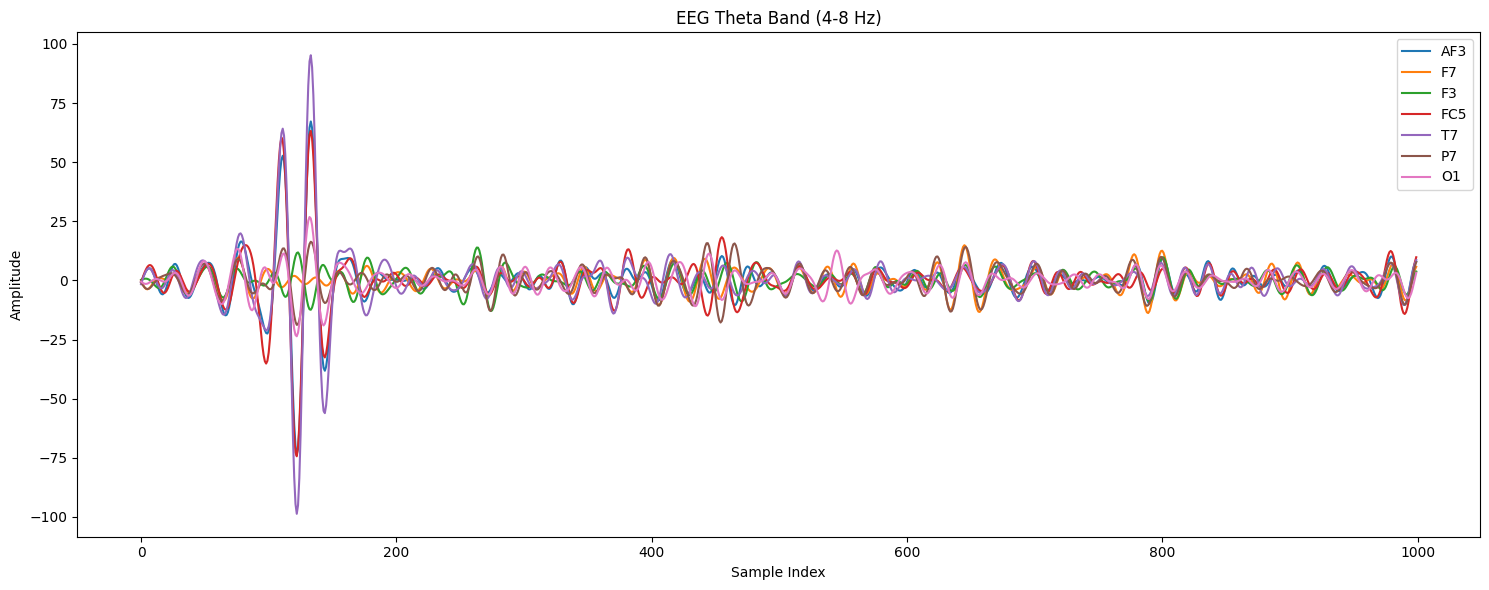

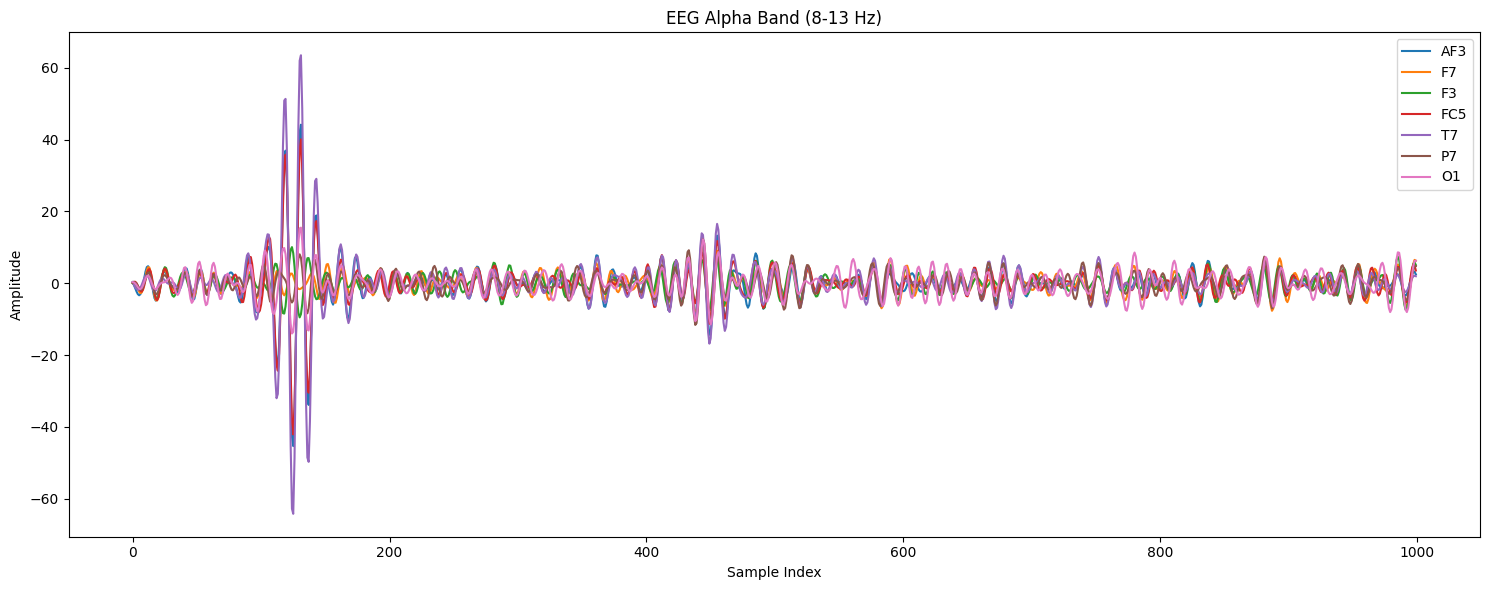

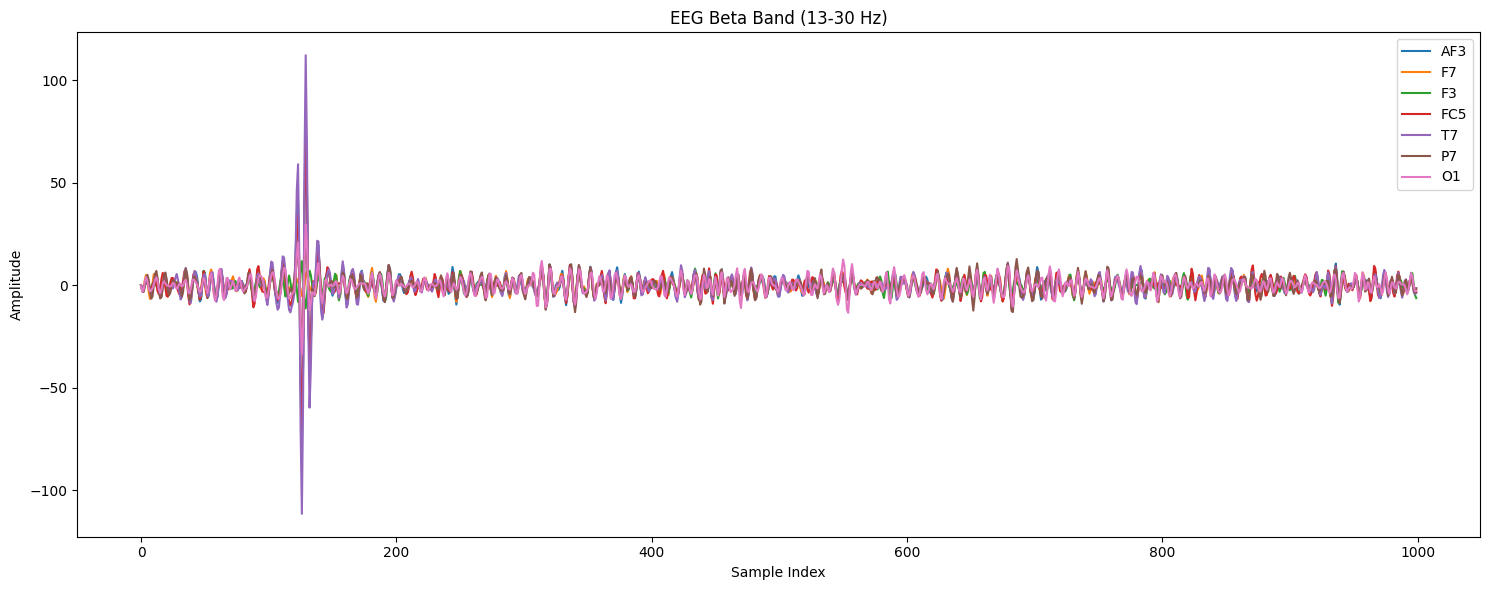

In [23]:
plot_frequency_bands(filtered_reduce_data_7channel[0])

# ICA

In [24]:
import mne
from mne.preprocessing import ICA

def apply_ica_to_data(filtered_data):
    ica_list = []
    raw_list = []

    for i in range(len(filtered_data)):

        data_one_day = filtered_data[i]

        # Tạo thông tin cho đối tượng Raw
        sfreq = 128  # Tần số lấy mẫu (giả sử là 128 Hz, bạn có thể thay đổi nếu khác)
        info = mne.create_info(ch_names=useful_channels_names, sfreq=sfreq, ch_types='eeg')

        # Lấy dữ liệu đã lọc từ danh sách, chuyển đổi thành dạng phù hợp cho MNE
        filtered_data_mne = data_one_day.T  # Chuyển thành (n_channels, n_times)

        # Tạo đối tượng Raw từ dữ liệu
        raw = mne.io.RawArray(filtered_data_mne, info)

        # Thêm montage vào đối tượng Raw với montage 'standard_1020'
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)

        # Áp dụng ICA để tách các thành phần độc lập
        ica = ICA(n_components=7, random_state=42, max_iter='auto')
        ica.fit(raw)

        # Lưu ICA và Raw để sử dụng sau
        ica_list.append(ica)
        raw_list.append(raw)

        # In ra thông báo đã xử lý xong
        print(f'Đã áp dụng ICA cho dữ liệu của người thứ {i+1}')

    return ica_list, raw_list

In [25]:
# Áp dụng hàm cho filtered_full_data và filtered_reduce_data
ica_full_data, raw_full_data = apply_ica_to_data(filtered_full_data_7channel)

ica_reduce_data = get_data_5days(ica_full_data)
raw_reduce_data = get_data_5days(raw_full_data)

Creating RawArray with float64 data, n_channels=7, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 1
Creating RawArray with float64 data, n_channels=7, n_times=366020
    Range : 0 ... 366019 =      0.000 ...  2859.523 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 2
Creating RawArray with float64 data, n_channels=7, n_times=357224
    Range : 0 ... 357223 =      0.000 ...  2790.805 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 3
Creating RawArray with float64 data, n_channels=7, n_times=380344
    Range : 0 ... 380343 =      0.000 ...  2971.430 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 4
Creating RawArray with float64 data, n_channels=7, n_times=351204
    Range : 0 ... 351203 =      0.000 ...  2743.773 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.0s.
Đã áp dụng ICA cho dữ liệu của người thứ 5
Creating RawArray with float64 data, n_channels=7, n_times=288752
    Range : 0 ... 288751 =      0.000 ...  2255.867 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.0s.
Đã áp dụng ICA cho dữ liệu của người thứ 6
Creating RawArray with float64 data, n_channels=7, n_times=398816
    Range : 0 ... 398815 =      0.000 ...  3115.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 7
Creating RawArray with float64 data, n_channels=7, n_times=365888
    Range : 0 ... 365887 =      0.000 ...  2858.492 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 8
Creating RawArray with float64 data, n_channels=7, n_times=388788
    Range : 0 ... 388787 =      0.000 ...  3037.398 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.8s.
Đã áp dụng ICA cho dữ liệu của người thứ 9
Creating RawArray with float64 data, n_channels=7, n_times=381340
    Range : 0 ... 381339 =      0.000 ...  2979.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.5s.
Đã áp dụng ICA cho dữ liệu của người thứ 10
Creating RawArray with float64 data, n_channels=7, n_times=391624
    Range : 0 ... 391623 =      0.000 ...  3059.555 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 11
Creating RawArray with float64 data, n_channels=7, n_times=356728
    Range : 0 ... 356727 =      0.000 ...  2786.930 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 12
Creating RawArray with float64 data, n_channels=7, n_times=373304
    Range : 0 ... 373303 =      0.000 ...  2916.430 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 13
Creating RawArray with float64 data, n_channels=7, n_times=345164
    Range : 0 ... 345163 =      0.000 ...  2696.586 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.8s.
Đã áp dụng ICA cho dữ liệu của người thứ 14
Creating RawArray with float64 data, n_channels=7, n_times=359164
    Range : 0 ... 359163 =      0.000 ...  2805.961 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 15
Creating RawArray with float64 data, n_channels=7, n_times=234372
    Range : 0 ... 234371 =      0.000 ...  1831.023 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 16
Creating RawArray with float64 data, n_channels=7, n_times=443972
    Range : 0 ... 443971 =      0.000 ...  3468.523 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.4s.
Đã áp dụng ICA cho dữ liệu của người thứ 17
Creating RawArray with float64 data, n_channels=7, n_times=361840
    Range : 0 ... 361839 =      0.000 ...  2826.867 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 18
Creating RawArray with float64 data, n_channels=7, n_times=333236
    Range : 0 ... 333235 =      0.000 ...  2603.398 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 19
Creating RawArray with float64 data, n_channels=7, n_times=396812
    Range : 0 ... 396811 =      0.000 ...  3100.086 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 20
Creating RawArray with float64 data, n_channels=7, n_times=336280
    Range : 0 ... 336279 =      0.000 ...  2627.180 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 21
Creating RawArray with float64 data, n_channels=7, n_times=324764
    Range : 0 ... 324763 =      0.000 ...  2537.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.8s.
Đã áp dụng ICA cho dữ liệu của người thứ 22
Creating RawArray with float64 data, n_channels=7, n_times=388088
    Range : 0 ... 388087 =      0.000 ...  3031.930 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.4s.
Đã áp dụng ICA cho dữ liệu của người thứ 23
Creating RawArray with float64 data, n_channels=7, n_times=360928
    Range : 0 ... 360927 =      0.000 ...  2819.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 24
Creating RawArray with float64 data, n_channels=7, n_times=415164
    Range : 0 ... 415163 =      0.000 ...  3243.461 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 25
Creating RawArray with float64 data, n_channels=7, n_times=363232
    Range : 0 ... 363231 =      0.000 ...  2837.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 26
Creating RawArray with float64 data, n_channels=7, n_times=347548
    Range : 0 ... 347547 =      0.000 ...  2715.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 1.0s.
Đã áp dụng ICA cho dữ liệu của người thứ 27
Creating RawArray with float64 data, n_channels=7, n_times=214540
    Range : 0 ... 214539 =      0.000 ...  1676.086 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 28
Creating RawArray with float64 data, n_channels=7, n_times=424608
    Range : 0 ... 424607 =      0.000 ...  3317.242 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.4s.
Đã áp dụng ICA cho dữ liệu của người thứ 29
Creating RawArray with float64 data, n_channels=7, n_times=349008
    Range : 0 ... 349007 =      0.000 ...  2726.617 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 0.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 30
Creating RawArray with float64 data, n_channels=7, n_times=428848
    Range : 0 ... 428847 =      0.000 ...  3350.367 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 31
Creating RawArray with float64 data, n_channels=7, n_times=483732
    Range : 0 ... 483731 =      0.000 ...  3779.148 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 32
Creating RawArray with float64 data, n_channels=7, n_times=483376
    Range : 0 ... 483375 =      0.000 ...  3776.367 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 33
Creating RawArray with float64 data, n_channels=7, n_times=408976
    Range : 0 ... 408975 =      0.000 ...  3195.117 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Administra\AppData\Local\Temp\ipykernel_14072\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 34


In [26]:
def plot_ica_components(ica_list, raw_list, num_files=2, reduce=False):
    # Nếu giảm dữ liệu, tính toán chỉ số file bắt đầu từ file thứ 3
    if reduce:
        start_index = 2  # Người thứ 1 bắt đầu từ file thứ 3
        step = 7  # Bước nhảy mỗi lần là 7 (người 2 từ file thứ 10, người 3 từ file thứ 17, v.v.)
    else:
        start_index = 0  # Nếu không giảm, bắt đầu từ file thứ 1
        step = 1  # Bước nhảy 1 file mỗi lần

    for i in range(num_files):
        # Tính chỉ số file dựa trên người và kiểu dữ liệu
        file_index = start_index + i * step
        if file_index < len(ica_list):
            print(f'Vẽ các thành phần ICA cho file thứ {file_index + 1}')

            # Vẽ các thành phần ICA
            ica_list[file_index].plot_components()

            # Vẽ tín hiệu của các thành phần ICA với Raw data
            ica_list[file_index].plot_sources(raw_list[file_index], start=0, stop=40, show_scrollbars=False)

            plt.show()

Vẽ các thành phần ICA cho file thứ 1


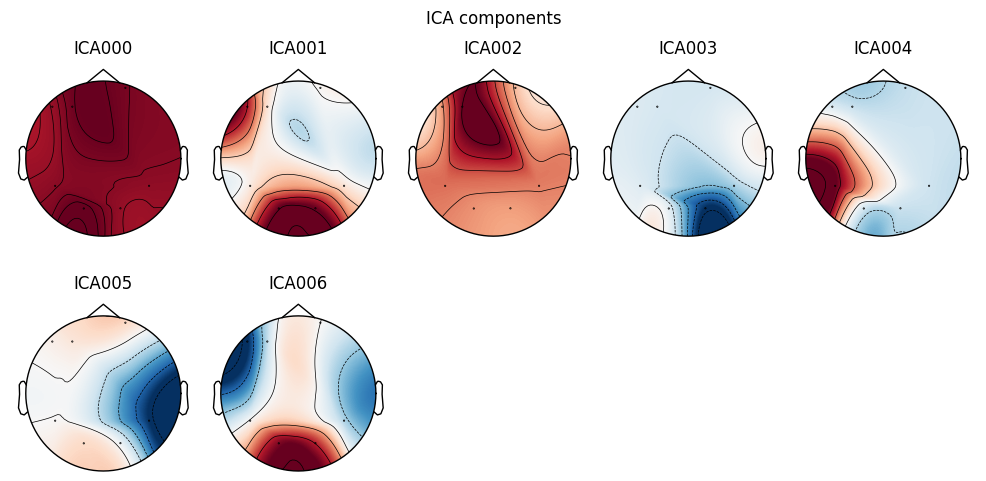

Creating RawArray with float64 data, n_channels=7, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.
Using matplotlib as 2D backend.


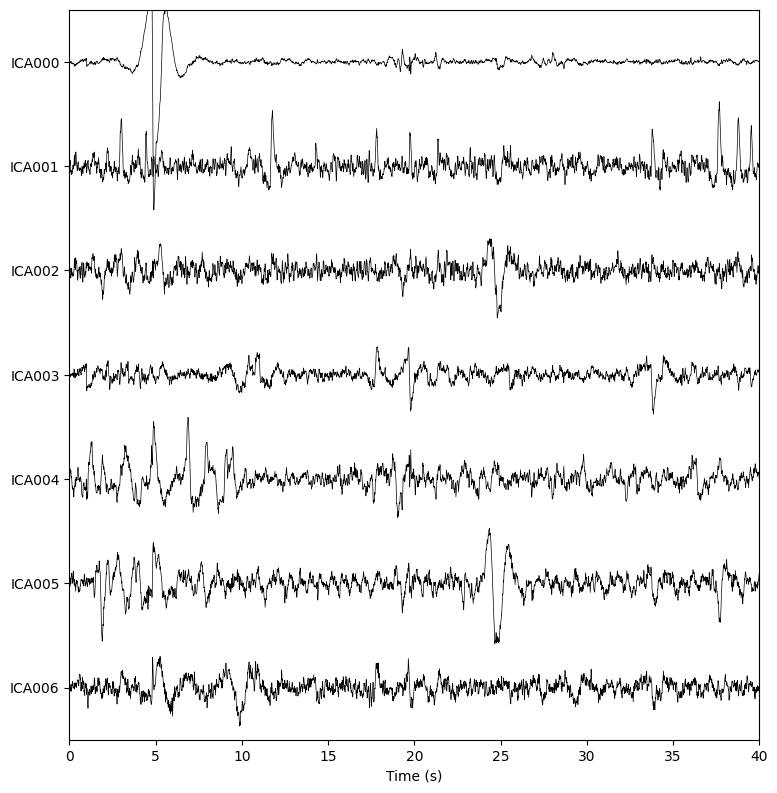

Vẽ các thành phần ICA cho file thứ 2


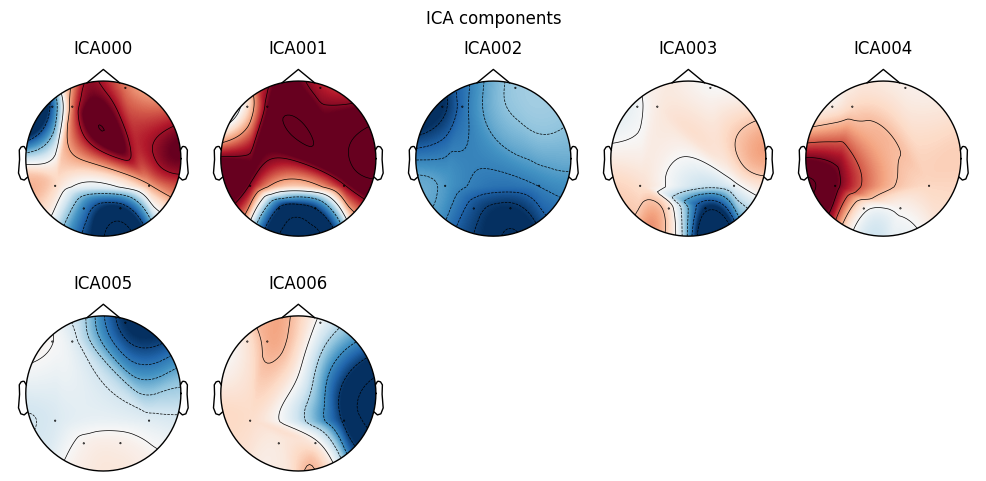

Creating RawArray with float64 data, n_channels=7, n_times=366020
    Range : 0 ... 366019 =      0.000 ...  2859.523 secs
Ready.


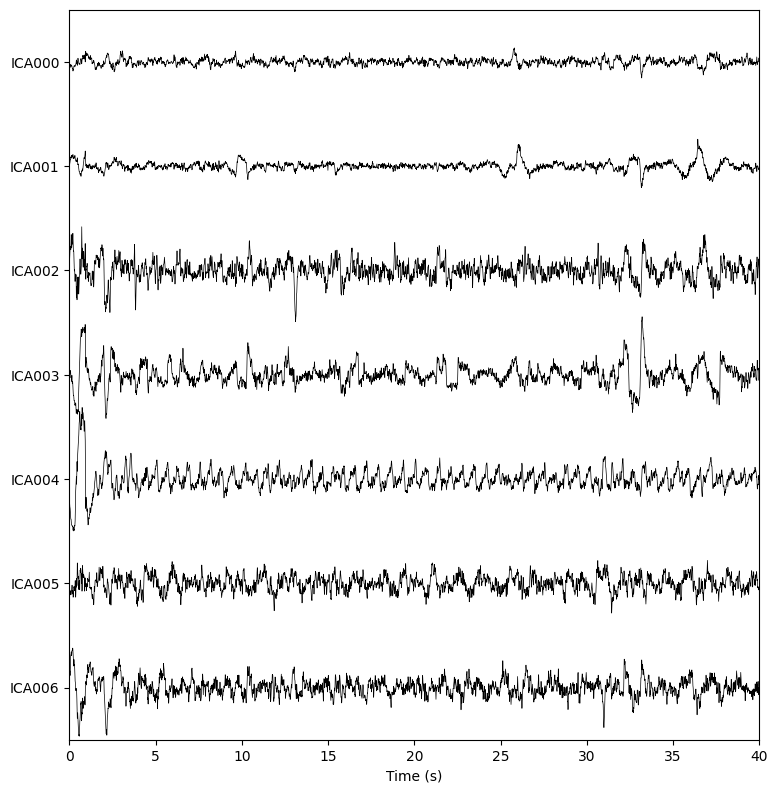

In [27]:
plot_ica_components(ica_full_data, raw_full_data)

Vẽ các thành phần ICA cho file thứ 3


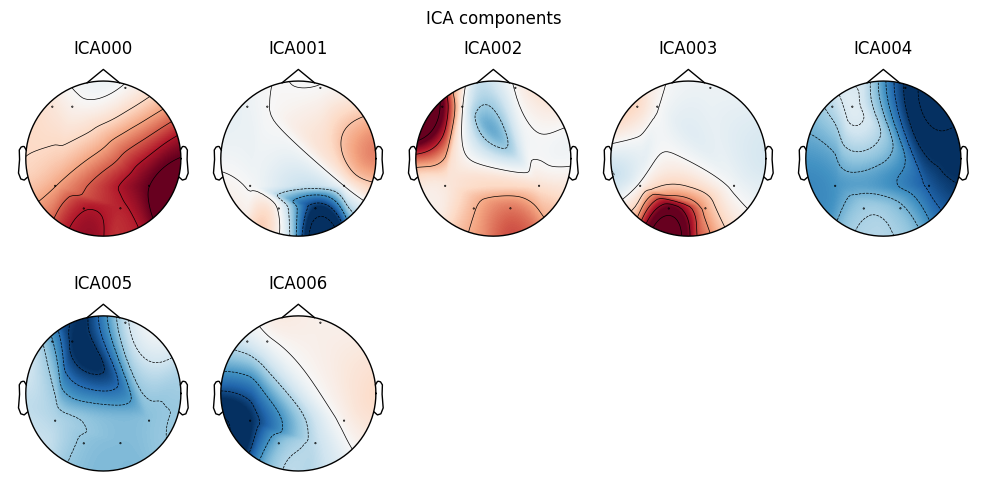

Creating RawArray with float64 data, n_channels=7, n_times=351204
    Range : 0 ... 351203 =      0.000 ...  2743.773 secs
Ready.


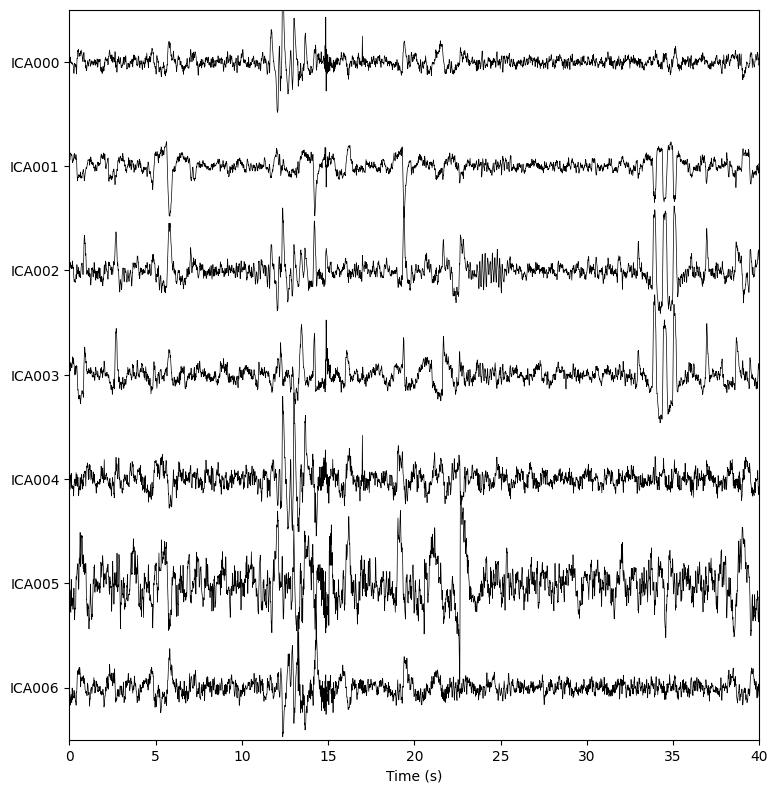

Vẽ các thành phần ICA cho file thứ 10


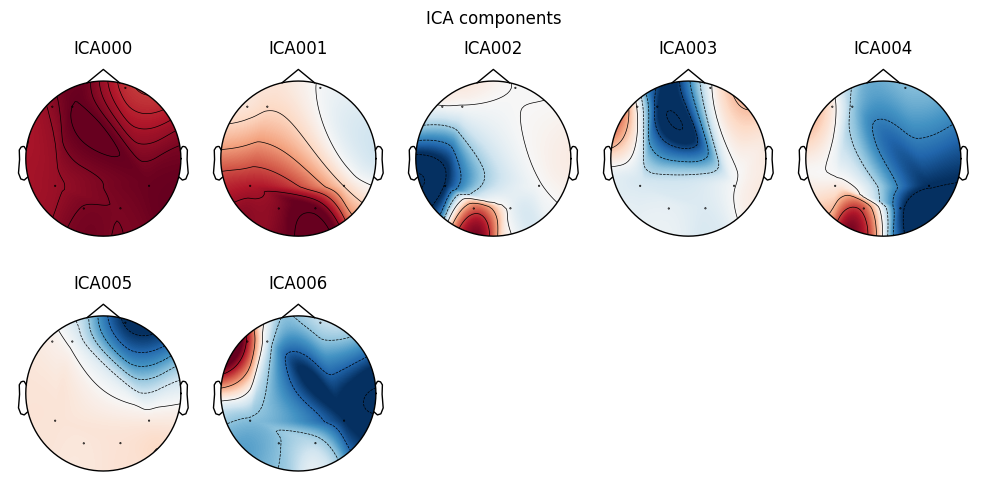

Creating RawArray with float64 data, n_channels=7, n_times=345164
    Range : 0 ... 345163 =      0.000 ...  2696.586 secs
Ready.


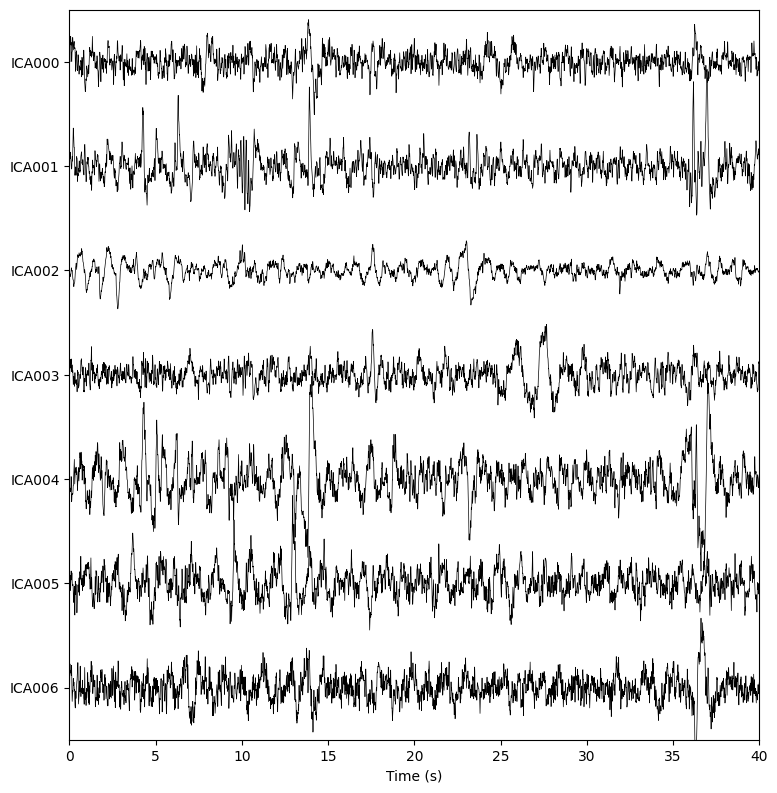

In [28]:
plot_ica_components(ica_reduce_data, raw_reduce_data, num_files=2, reduce=True)

In [29]:
def detect_eog_artifacts(ica, raw, eye_channels):
    all_eog_indices = {}

    for ch in eye_channels:
        if ch in raw.ch_names:  # Kiểm tra nếu kênh có tồn tại trong đối tượng Raw
            try:
                # Phát hiện nhiễu nháy mắt (EOG)
                eog_indices, _ = ica.find_bads_eog(raw, ch_name=ch)
                all_eog_indices[ch] = eog_indices
                # print(f"Các thành phần ICA liên quan đến nháy mắt với kênh {ch}: {eog_indices}")
            except Exception as e:
                print(f"Lỗi khi chạy với kênh {ch}: {e}")

    return all_eog_indices

def detect_ecg_artifacts(ica, raw, heart_related_channels):
    all_ecg_indices = {}

    for ch in heart_related_channels:
        if ch in raw.ch_names:  # Kiểm tra nếu kênh có tồn tại trong đối tượng Raw
            try:
                # Phát hiện nhiễu nhịp tim (ECG)
                ecg_indices, _ = ica.find_bads_ecg(raw, ch_name=ch)
                all_ecg_indices[ch] = ecg_indices
                # print(f"Các thành phần ICA liên quan đến nhịp tim với kênh {ch}: {ecg_indices}")
            except Exception as e:
                print(f"Lỗi khi chạy với kênh {ch}: {e}")

    return all_ecg_indices

def print_indices_results(all_eog_indices, all_ecg_indices):
    # In kết quả EOG
    print("\nKết quả từ tất cả các kênh EOG:")
    for ch, indices in all_eog_indices.items():
        print(f"Kênh {ch}: Thành phần ICA {indices}")

    # In kết quả ECG
    print("\nKết quả từ tất cả các kênh ECG:")
    for ch, indices in all_ecg_indices.items():
        print(f"Kênh {ch}: Thành phần ICA {indices}")

In [30]:
def detect_artifacts(ica_list, raw_list):
    # Danh sách các kênh bị ảnh hưởng nhiễu từ mắt và tim
    eye_channels = ['F7']
    heart_channels = ['F7']

    eog_indices = []
    ecg_indices = []

    # Duyệt qua từng file trong raw_list và ica_list
    for i in range(len(raw_list)):
        print(f"\nKết quả cho file #{i + 1}:")
        
        # Phát hiện nhiễu EOG và ECG cho từng file
        eog = detect_eog_artifacts(ica_list[i], raw_list[i], eye_channels)
        ecg = detect_ecg_artifacts(ica_list[i], raw_list[i], heart_channels)

        eog_indices.append(eog)
        ecg_indices.append(ecg)


    return eog_indices, ecg_indices

In [31]:
eog_indices_full, ecg_indices_full = detect_artifacts(ica_full_data, raw_full_data)


Kết quả cho file #1:
Using EOG channel: F7
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff fr

In [32]:
eog_indices_reduce = get_data_5days(eog_indices_full)
ecg_indices_reduce = get_data_5days(ecg_indices_full)

In [33]:
def get_artifacts_table(eog_indices, ecg_indices, data_type="EOG"):
    
    # Khởi tạo danh sách các kênh
    channels = ['F7','F3','P7','O1','O2','P8','AF4']

    # Dữ liệu sẽ chứa thông tin từng chỉ số ICA bị nhiễu cho các kênh
    artifact_data = {channel: [] for channel in channels}

    # Duyệt qua từng file để lấy các chỉ số ICA nhiễu
    for artifact in (eog_indices if data_type == "EOG" else ecg_indices):
        for channel in channels:
            # Lấy các thành phần ICA bị nhiễu cho kênh này
            artifact_data[channel].append(artifact.get(channel, []))

    # Chuyển thành DataFrame
    artifact_df = pd.DataFrame(artifact_data)

    # Trả về bảng kết quả
    return artifact_df.transpose()  # Trả về DataFrame với mỗi file là một cột

# In kết quả EOG - Dữ liệu đầy đủ
eog_full_df = get_artifacts_table(eog_indices_full, ecg_indices_full, data_type="EOG")
print("Các chỉ số ICA bị nhiễu mắt (EOG) - Dữ liệu đầy đủ:")
print(eog_full_df)

# In kết quả EOG - Dữ liệu giảm
eog_reduce_df = get_artifacts_table(eog_indices_reduce, ecg_indices_reduce, data_type="EOG")
print("\nCác chỉ số ICA bị nhiễu mắt (EOG) - Dữ liệu giảm:")
print(eog_reduce_df)

# In kết quả ECG - Dữ liệu đầy đủ
ecg_full_df = get_artifacts_table(eog_indices_full, ecg_indices_full, data_type="ECG")
print("\nCác chỉ số ICA bị nhiễu tim (ECG) - Dữ liệu đầy đủ:")
print(ecg_full_df)

# In kết quả ECG - Dữ liệu giảm
ecg_reduce_df = get_artifacts_table(eog_indices_reduce, ecg_indices_reduce, data_type="ECG")
print("\nCác chỉ số ICA bị nhiễu tim (ECG) - Dữ liệu giảm:")
print(ecg_reduce_df)

Các chỉ số ICA bị nhiễu mắt (EOG) - Dữ liệu đầy đủ:
     0   1   2   3   4   5   6   7   8   9   ...  24  25  26  27  28  29  30  \
F7   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
F3   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
P7   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
O1   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
O2   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
P8   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
AF4  []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   

     31  32  33  
F7   []  []  []  
F3   []  []  []  
P7   []  []  []  
O1   []  []  []  
O2   []  []  []  
P8   []  []  []  
AF4  []  []  []  

[7 rows x 34 columns]

Các chỉ số ICA bị nhiễu mắt (EOG) - Dữ liệu giảm:
     0   1   2   3   4   5   6   7   8   9   ...  14  15  16  17  18  19  20  \
F7   []  

In [34]:
def exclude_ica_components_for_all(ica_list, raw_list, eog_indices_list, ecg_indices_list):

    excluded_raw_list = []
    excluded_ica_list = []

    for idx, ica in enumerate(ica_list):
        print(f"\nĐang loại bỏ thành phần ICA cho file #{idx + 1}:")
        
        # Lấy chỉ số EOG và ECG cho từng file
        eog_indices = eog_indices_list[idx]
        ecg_indices = ecg_indices_list[idx]
        
        # Tạo bản sao của raw để giữ dữ liệu gốc và dữ liệu đã loại trừ riêng biệt
        raw_copy = raw_list[idx].copy()

        # Loại bỏ các thành phần ICA cho EOG và ECG
        all_exclude_indices = []
        
        # Thêm các thành phần ICA bị nhiễu EOG và ECG vào danh sách loại trừ
        for eog in eog_indices.values():  # Duyệt qua các chỉ số EOG
            all_exclude_indices.extend(eog)
        
        for ecg in ecg_indices.values():  # Duyệt qua các chỉ số ECG
            all_exclude_indices.extend(ecg)
        
        # Loại bỏ các thành phần ICA trong ica.exclude
        ica.exclude = list(set(all_exclude_indices))  # Loại bỏ trùng lặp
        print(f"Đã loại bỏ các thành phần ICA: {ica.exclude}")
        
        # Áp dụng ICA sau khi loại trừ
        ica.apply(raw_copy)  # Áp dụng loại trừ vào bản sao của raw

        # Thêm dữ liệu đã loại trừ vào danh sách kết quả
        excluded_raw_list.append(raw_copy)
        excluded_ica_list.append(ica)  # Lưu lại đối tượng ICA đã loại trừ

        print(f"Đã loại trừ thành công cho file #{idx + 1}")
    
    return excluded_ica_list ,excluded_raw_list

# Sử dụng với dữ liệu đầy đủ (full_data) và dữ liệu giảm (reduce_data)
excluded_ica_full, excluded_raw_full = exclude_ica_components_for_all(ica_full_data, raw_full_data, eog_indices_full, ecg_indices_full)

# excluded_raw_reduce_data = exclude_ica_components_for_all(ica_reduce_data, raw_reduce_data, eog_indices_reduce, ecg_indices_reduce)
excluded_ica_reduce = get_data_5days(excluded_ica_full)
excluded_raw_reduce = get_data_5days(excluded_raw_full)


Đang loại bỏ thành phần ICA cho file #1:
Đã loại bỏ các thành phần ICA: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA components
Đã loại trừ thành công cho file #1

Đang loại bỏ thành phần ICA cho file #2:
Đã loại bỏ các thành phần ICA: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA components
Đã loại trừ thành công cho file #2

Đang loại bỏ thành phần ICA cho file #3:
Đã loại bỏ các thành phần ICA: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA components
Đã loại trừ thành công cho file #3

Đang loại bỏ thành phần ICA cho file #4:
Đã loại bỏ các thành phần ICA: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA co

Vẽ các thành phần ICA cho file thứ 1


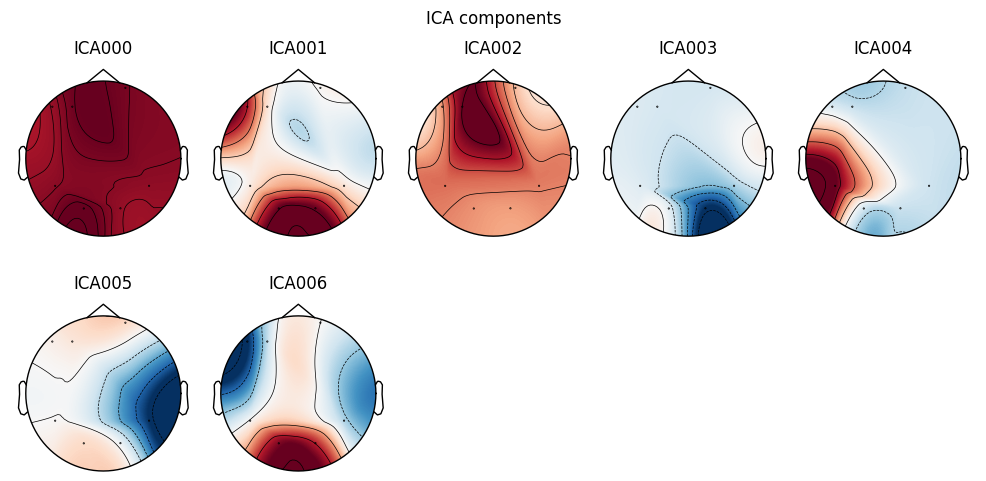

Creating RawArray with float64 data, n_channels=7, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.


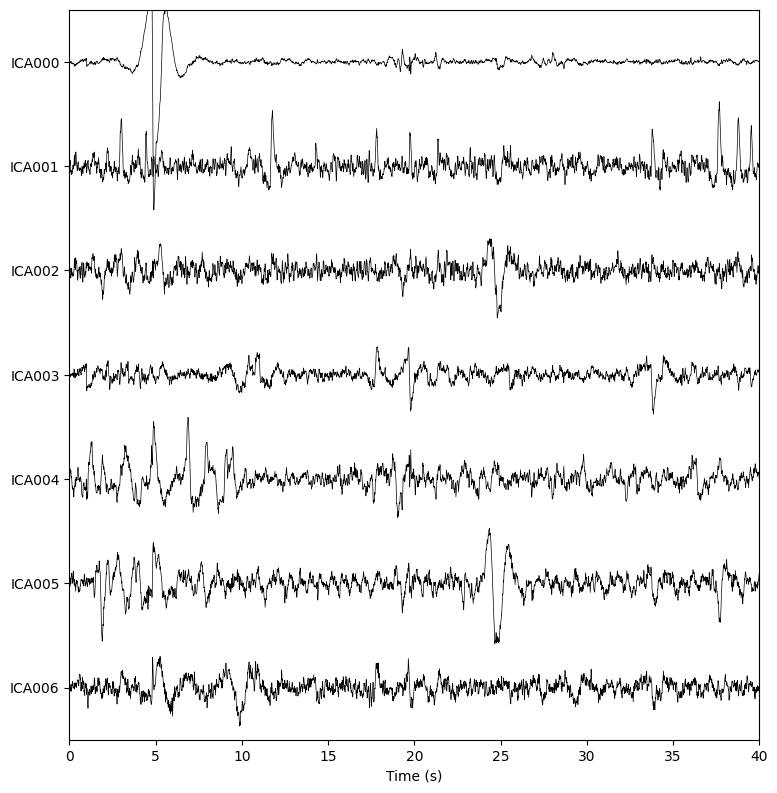

Vẽ các thành phần ICA cho file thứ 2


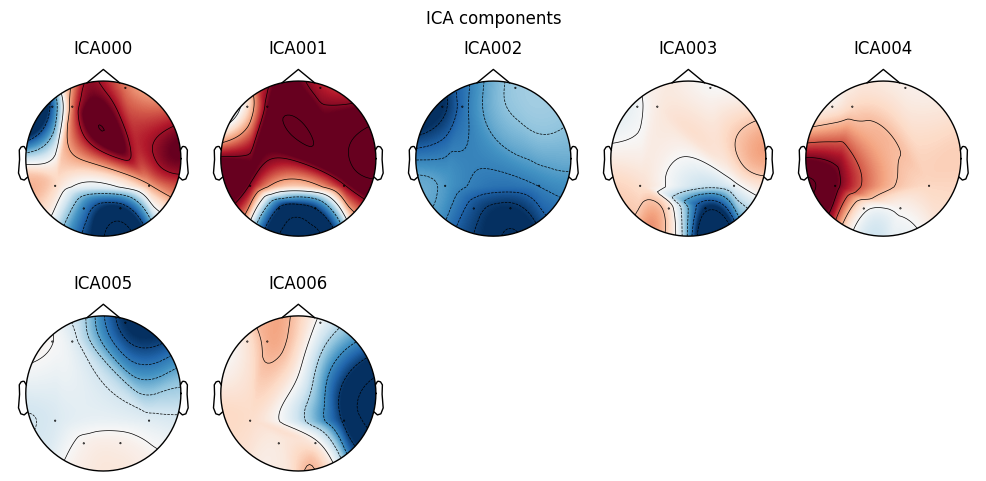

Creating RawArray with float64 data, n_channels=7, n_times=366020
    Range : 0 ... 366019 =      0.000 ...  2859.523 secs
Ready.


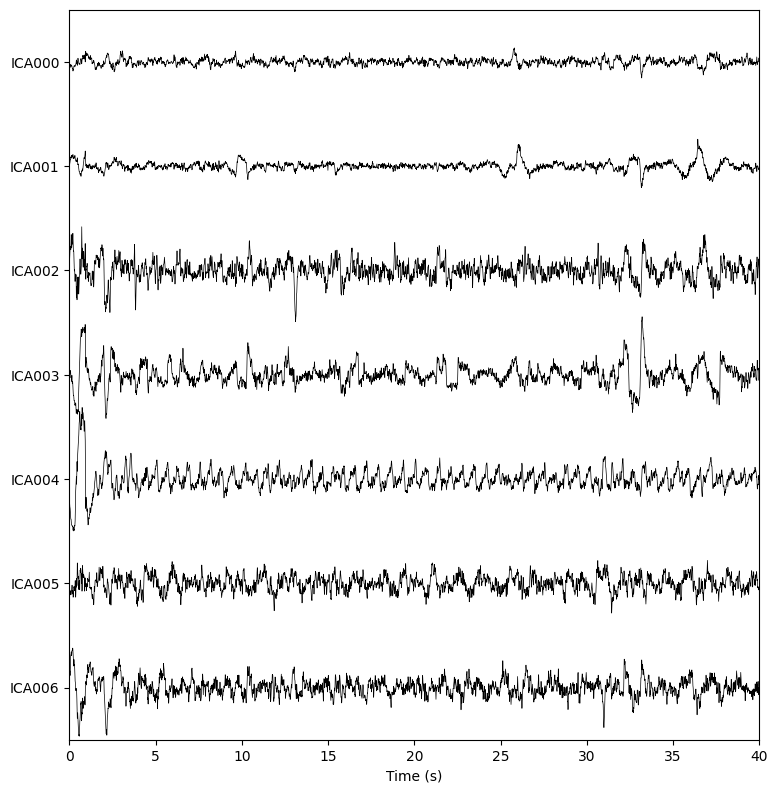

In [35]:
plot_ica_components(ica_full_data, raw_full_data)

Vẽ các thành phần ICA cho file thứ 1


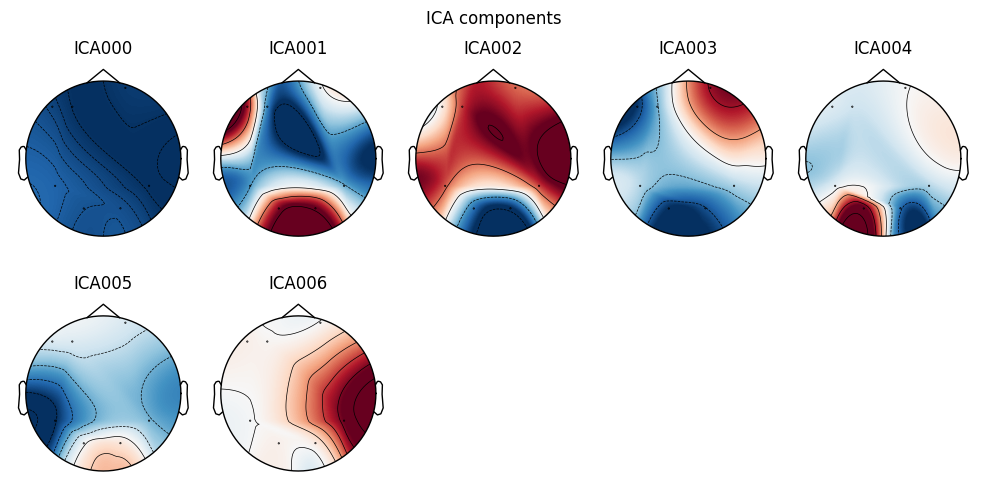

Creating RawArray with float64 data, n_channels=7, n_times=357224
    Range : 0 ... 357223 =      0.000 ...  2790.805 secs
Ready.


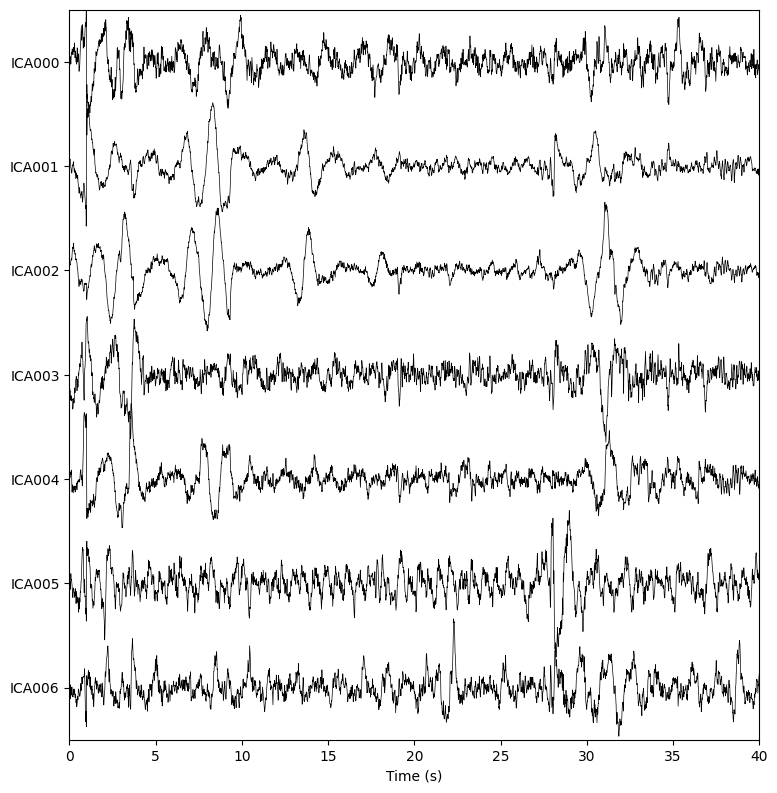

Vẽ các thành phần ICA cho file thứ 2


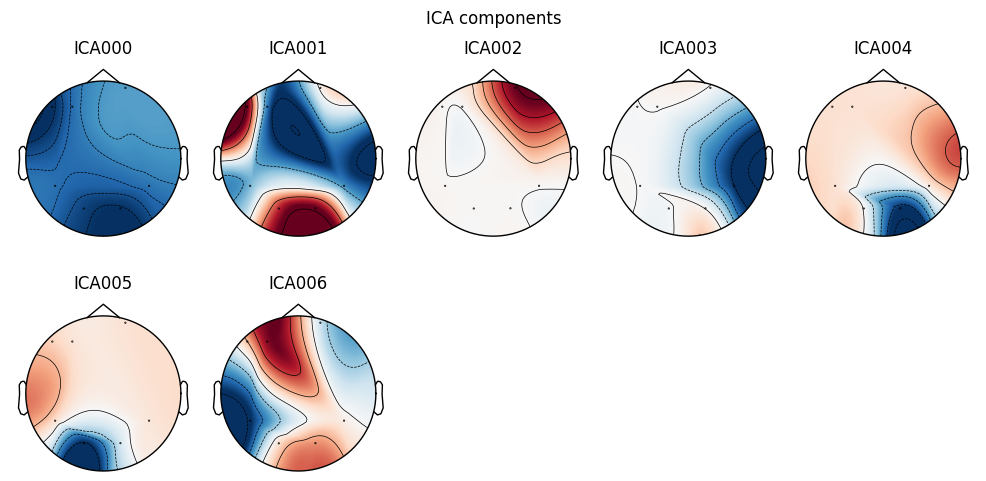

Creating RawArray with float64 data, n_channels=7, n_times=380344
    Range : 0 ... 380343 =      0.000 ...  2971.430 secs
Ready.


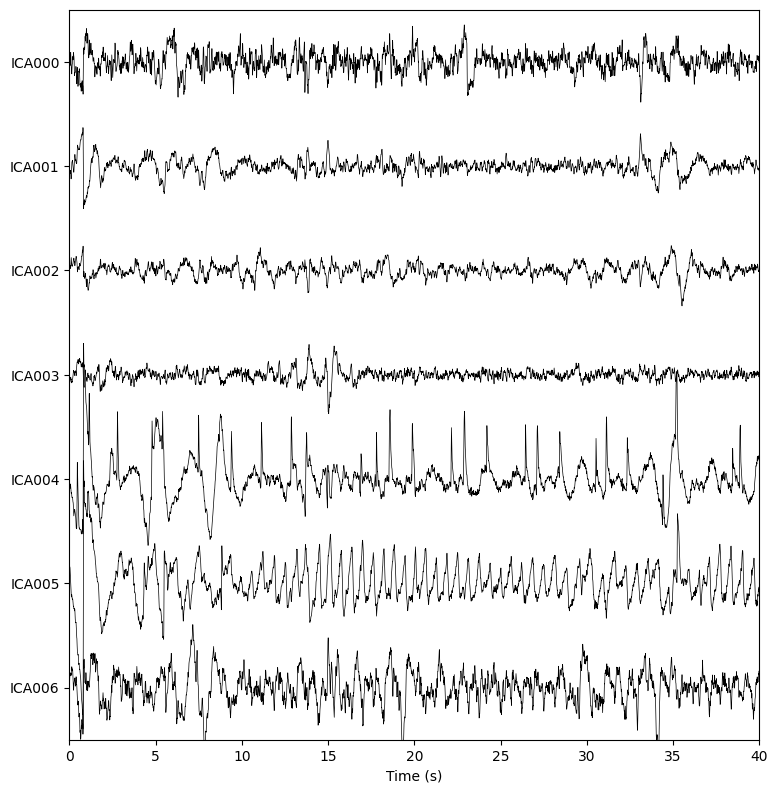

In [36]:
plot_ica_components(ica_reduce_data, raw_reduce_data)

In [37]:
# Lưu dữ liệu vào một dictionary với keys là 'file_1', 'file_2', ...
full_data_ICA = {}
reduce_data_ICA = {}

for idx, raw in enumerate(excluded_raw_full):
    file_key = f"file_{idx + 1}"  # Key cho từng file (file_1, file_2, ...)
    full_data_ICA[file_key] = raw.get_data().T  # Lưu dữ liệu của file vào dictionary

for idx, raw in enumerate(excluded_raw_reduce):
    file_key = f"file_{idx + 1}"  # Key cho từng file (file_1, file_2, ...)
    reduce_data_ICA[file_key] = raw.get_data().T  # Lưu dữ liệu của file vào dictionary

In [38]:
# In thử data của 1 file 
full_data_ICA['file_1']

array([[ 6.57047172,  4.07116267,  4.02036296, ...,  5.81810913,
         4.35043234,  6.42530967],
       [ 7.64045213,  3.33447351,  7.0301308 , ...,  7.03656787,
         5.27359691,  8.16527911],
       [ 7.45826227,  2.11681028,  6.14721947, ...,  7.41534662,
         5.87179025,  6.53676764],
       ...,
       [20.2435573 , 16.1707712 , 20.79365868, ..., 20.82856991,
         3.73162808, 15.26894109],
       [19.27838233, 15.29511581, 17.05681164, ..., 19.38353124,
         5.30686237, 14.8578989 ],
       [15.88845729, 15.10874383, 11.9387759 , ..., 16.63743163,
        13.00576218, 16.17590888]])

In [39]:
full_data_ICA['file_1'].shape

(308868, 7)

In [48]:
reduce_data_ICA

{'file_1': array([[24.19749715,  6.000844  ,  4.23830329, ..., 16.96838106,
         10.22124606,  1.91832993],
        [19.72127985,  2.85110049,  3.29300664, ..., 14.33737549,
          5.4407345 , -3.05514881],
        [19.0679392 ,  3.3923298 ,  3.41850959, ..., 12.97791356,
          3.86129927, -3.880416  ],
        ...,
        [12.42305188, 18.81125479,  7.11168582, ..., 13.9125882 ,
         12.92372268,  6.00828526],
        [ 8.8658258 , 14.07675821,  6.68788509, ..., 11.32867891,
         10.06841613,  4.72079507],
        [ 2.85255593,  5.58936839,  2.62482199, ...,  1.51582002,
          5.10406494,  3.4232087 ]]),
 'file_2': array([[ -6.75091581,   0.97402038,  -4.83068237, ..., -10.81059783,
           6.20316657,  -5.9723539 ],
        [ -2.54908266,   9.80281058,   3.92012574, ...,  -5.83730209,
          17.65620756,   2.08026862],
        [ -2.23339941,  12.19591815,   4.22821803, ...,  -2.70794101,
          21.10909497,   6.31305377],
        ...,
        [  6.680

# Extract

In [104]:
# def restructure_data(reduce_data_ICA, fs=128):

#     # Tạo từ điển để lưu trữ dữ liệu
#     data_dict = {
#         'Focused': {},
#         'Unfocused': {},
#         'Drowsy': {}
#     }

#     # Định nghĩa số mẫu cho mỗi khoảng thời gian
#     samples_per_minute = fs * 60  # Số mẫu trong 1 phút
#     samples_10_minutes = samples_per_minute * 10  # Số mẫu trong 10 phút
#     samples_20_minutes = samples_per_minute * 20  # Số mẫu trong 20 phút

#     # Chia dữ liệu cho từng người và từng trạng thái
#     for person_idx in range(5):
#         # Tính chỉ số file bắt đầu và kết thúc cho mỗi người
#         start_file_idx = person_idx * 5
#         num_files = 5 if person_idx != 4 else 4

#         # Lưu trữ dữ liệu cho mỗi người
#         person_focus = []
#         person_unfocus = []
#         person_drowsy = []

#         for file_idx in range(start_file_idx, start_file_idx + num_files):
#             file_key = f"file_{file_idx + 1}"
#             data = reduce_data_ICA[file_key]
#             n_samples, n_channels = data.shape

#             # Chia dữ liệu thành 3 phần: focused, unfocused, drowsy
#             focus_data = data[:samples_10_minutes, :]
#             unfocus_data = data[samples_10_minutes:samples_10_minutes * 2, :]
#             drowsy_data = data[samples_10_minutes * 2:, :]

#             # Thêm dữ liệu vào danh sách tương ứng cho mỗi trạng thái
#             person_focus.append(focus_data)
#             person_unfocus.append(unfocus_data)
#             person_drowsy.append(drowsy_data)

#         # Ghép tất cả các file lại thành một mảng duy nhất cho mỗi trạng thái
#         subject_key = f"subject_{person_idx + 1}"
#         data_dict['Focused'][subject_key] = np.concatenate(person_focus, axis=0)
#         data_dict['Unfocused'][subject_key] = np.concatenate(person_unfocus, axis=0)
#         data_dict['Drowsy'][subject_key] = np.concatenate(person_drowsy, axis=0)

#     return data_dict


def restructure_data(reduce_data_ICA, fs=128):
    # Tạo từ điển để lưu trữ dữ liệu
    data_dict = {
        'Focused': {},
        'Unfocused': {},
        'Drowsy': {}
    }
 
    # Định nghĩa số mẫu cho mỗi khoảng thời gian
    samples_per_minute = fs * 60  # Số mẫu trong 1 phút
    samples_10_minutes = samples_per_minute * 10  # Số mẫu trong 10 phút
    samples_20_minutes = samples_per_minute * 20  # Số mẫu trong 20 phút

    # Chia dữ liệu cho từng người và từng trạng thái
    for file_key, data in reduce_data_ICA.items():
        # Kiểm tra có file không
        if file_key not in reduce_data_ICA:
            continue

        # Chia dữ liệu thành 3 phần: focused, unfocused, drowsy
        focus_data = data[:samples_10_minutes, :]
        unfocus_data = data[samples_10_minutes:samples_10_minutes * 2, :]
        drowsy_data = data[samples_10_minutes * 2:, :]

        # Lưu trữ dữ liệu cho các trạng thái
        if 'file' in file_key:
            subject_key = file_key  # Sử dụng tên file làm key
            data_dict['Focused'][subject_key] = focus_data
            data_dict['Unfocused'][subject_key] = unfocus_data
            data_dict['Drowsy'][subject_key] = drowsy_data

    return data_dict


In [105]:
data_dict = restructure_data(reduce_data_ICA)

In [106]:
data_dict

{'Focused': {'file_1': array([[ 24.19749715,   6.000844  ,   4.23830329, ...,  16.96838106,
           10.22124606,   1.91832993],
         [ 19.72127985,   2.85110049,   3.29300664, ...,  14.33737549,
            5.4407345 ,  -3.05514881],
         [ 19.0679392 ,   3.3923298 ,   3.41850959, ...,  12.97791356,
            3.86129927,  -3.880416  ],
         ...,
         [ -0.28155099,  50.20058714,  53.85385125, ..., -25.804     ,
           45.52720325,   9.87031701],
         [ -8.61901116,  40.09076436,  46.10443682, ..., -29.73870852,
           36.01721502,   0.30084403],
         [-20.52610441,  27.52399184,  36.18596241, ..., -36.41044807,
           23.14074918,  -8.4927055 ]]),
  'file_2': array([[ -6.75091581,   0.97402038,  -4.83068237, ..., -10.81059783,
            6.20316657,  -5.9723539 ],
         [ -2.54908266,   9.80281058,   3.92012574, ...,  -5.83730209,
           17.65620756,   2.08026862],
         [ -2.23339941,  12.19591815,   4.22821803, ...,  -2.70794101,
  

In [74]:
import numpy as np
from scipy.signal import stft

# 1. Hàm tạo cửa sổ Blackman-Harris
def create_blackman_harris_window(M=128):
    t_win = np.arange(0, M)
    window_blackman = 0.42 - 0.5 * np.cos((2 * np.pi * t_win) / (M - 1)) + 0.08 * np.cos((4 * np.pi * t_win) / (M - 1))
    return window_blackman

# 2. Hàm tính STFT và công suất phổ
def compute_stft_power(data, fs, window, nperseg, nfft=1024):
    f, t, Zxx = stft(data, fs=fs, window=window, nperseg=nperseg, noverlap=0, nfft=nfft,
                     detrend=False, return_onesided=True, boundary='zeros', padded=True)
    power = (np.abs(Zxx)) ** 2

    # Đảm bảo kết quả có 3 chiều: (num_channels, num_frequencies, num_segments)
    if power.ndim == 2:
        power = power[np.newaxis, :, :]  # Thêm chiều kênh nếu chỉ có 2 chiều
    return power

# 3. Hàm tính trung bình dải tần 
def combine_frequency_bins_by_band(power, fs, bands):
    """
    Tính toán công suất theo dải tần cụ thể.

    Args:
        power: Mảng công suất STFT có kích thước (num_channels, num_frequencies, num_segments).
        fs: Tần số mẫu (sampling frequency).
        bands: Dictionary chứa các dải tần, ví dụ:
               {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}

    Returns:
        Mảng đã trung bình hóa theo dải tần có kích thước (num_channels, len(bands), num_segments).
    """
    if len(power.shape) < 3:
        raise ValueError("Input 'power' must have at least 3 dimensions: (num_channels, num_frequencies, num_segments)")

    num_channels, num_frequencies, num_segments = power.shape
    band_power = np.zeros((num_channels, len(bands), num_segments))

    freqs = np.linspace(0, fs / 2, num_frequencies)  # Các tần số tương ứng với các bin
    for band_idx, (band_name, (low_freq, high_freq)) in enumerate(bands.items()):
        # Xác định chỉ số các tần số trong khoảng dải tần
        band_indices = np.where((freqs >= low_freq) & (freqs < high_freq))[0]
        if len(band_indices) == 0:
            raise ValueError(f"No frequency bins found for band {band_name}. Check the band range.")
        # Tính trung bình trên các chỉ số dải tần
        band_power[:, band_idx, :] = np.mean(power[:, band_indices, :], axis=1)

    return band_power

# 4. Hàm tính trung bình di động trên cửa sổ 15 giây
def moving_average_window(data, window_size=15):
    num_segments = data.shape[2] - window_size + 1
    averaged_data = np.zeros((data.shape[0], data.shape[1], num_segments))
    for chn in range(data.shape[0]):
        for j in range(num_segments):
            averaged_data[chn, :, j] = np.average(data[chn, :, j:j + window_size], axis=1)
    return averaged_data

# 5. Hàm chuyển đổi dữ liệu thành vector đặc trưng
def create_model_features(power_ave):
    num_channels = power_ave.shape[0]
    num_bins = power_ave.shape[1]
    num_segments = power_ave.shape[2]

    model_features = np.zeros((num_channels * num_bins, num_segments))
    for j in range(num_segments):
        model_features[:, j] = power_ave[:, :, j].reshape(-1)

    # Áp dụng logarit cho dữ liệu
    model_features = 10 * np.log(model_features)
    return model_features

def extract_features_from_data(data_dict, fs=128):
    # Lấy danh sách tên các đối tượng từ data_dict
    trail_names = list(data_dict['Focused'].keys())
    nperseg = 128
    window = create_blackman_harris_window(M=nperseg)

    power_focus = {}
    power_unfocus = {}
    power_drowsy = {}

    # Tính STFT và công suất phổ cho từng trạng thái
    for name in trail_names:
        power_focus[name] = []
        power_unfocus[name] = []
        power_drowsy[name] = []

        for i in range(data_dict['Focused'][name].shape[1]):
            # Sử dụng các khóa 'Focused', 'Unfocused', 'Drowsy' đúng với cấu trúc của data_dict
            power_focus_result = compute_stft_power(data_dict['Focused'][name][:, i], fs, window, nperseg)
            power_unfocus_result = compute_stft_power(data_dict['Unfocused'][name][:, i], fs, window, nperseg)
            power_drowsy_result = compute_stft_power(data_dict['Drowsy'][name][:, i], fs, window, nperseg)

            # Thêm kết quả STFT vào danh sách
            power_focus[name].append(power_focus_result)
            power_unfocus[name].append(power_unfocus_result)
            power_drowsy[name].append(power_drowsy_result)

        # Chuyển đổi danh sách thành mảng numpy với kích thước phù hợp
        power_focus[name] = np.concatenate(power_focus[name], axis=0)
        power_unfocus[name] = np.concatenate(power_unfocus[name], axis=0)
        power_drowsy[name] = np.concatenate(power_drowsy[name], axis=0)

    # Trung bình dải tần 0.5Hz
    power_focus_bin = {}
    power_unfocus_bin = {}
    power_drowsy_bin = {}

    bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30)
    }

    # Áp dụng cho các trạng thái Focused, Unfocused, Drowsy
    for name in trail_names:
        power_focus_bin[name] = combine_frequency_bins_by_band(power_focus[name], fs, bands)
        power_unfocus_bin[name] = combine_frequency_bins_by_band(power_unfocus[name], fs, bands)
        power_drowsy_bin[name] = combine_frequency_bins_by_band(power_drowsy[name], fs, bands)


    # Trung bình di động trên cửa sổ 15 giây
    power_focus_ave = {}
    power_unfocus_ave = {}
    power_drowsy_ave = {}

    for name in trail_names:
        power_focus_ave[name] = moving_average_window(power_focus_bin[name])
        power_unfocus_ave[name] = moving_average_window(power_unfocus_bin[name])
        power_drowsy_ave[name] = moving_average_window(power_drowsy_bin[name])

    # Chuyển đổi thành vector đặc trưng cho SVM
    model_data_focus = {}
    model_data_unfocus = {}
    model_data_drowsy = {}

    for name in trail_names:
        model_data_focus[name] = create_model_features(power_focus_ave[name])
        model_data_unfocus[name] = create_model_features(power_unfocus_ave[name])
        model_data_drowsy[name] = create_model_features(power_drowsy_ave[name])
 
    return model_data_focus, model_data_unfocus, model_data_drowsy


In [43]:
model_data_focus, model_data_unfocus, model_data_drowsy = extract_features_from_data(data_dict)

In [75]:
# Hàm kết hợp dữ liệu và tạo nhãn cho từng trạng thái
def combine_data_with_labels(model_data_focus, model_data_unfocus, model_data_drowsy):
    # Lấy tất cả các tên đối tượng
    all_subjects = list(model_data_focus.keys())

    # Kết hợp dữ liệu của các trạng thái Not-Drowsy (Focused và Unfocused)
    X_focus = np.concatenate([model_data_focus[subject] for subject in all_subjects], axis=1)
    X_unfocus = np.concatenate([model_data_unfocus[subject] for subject in all_subjects], axis=1)
    X_drowsy = np.concatenate([model_data_drowsy[subject] for subject in all_subjects], axis=1)

    # Ghép tất cả các dữ liệu lại
    X = np.concatenate([X_focus, X_unfocus, X_drowsy], axis=1).T  # Chuyển vị để có dạng (n_samples, n_features)

    # Tạo nhãn cho từng trạng thái
    y_focus = ['Focused'] * X_focus.shape[1]  # Nhãn 'Focused' cho trạng thái Focused
    y_unfocus = ['Unfocused'] * X_unfocus.shape[1]  # Nhãn 'Unfocused' cho trạng thái Unfocused
    y_drowsy = ['Drowsy'] * X_drowsy.shape[1]  # Nhãn 'Drowsy' cho trạng thái Drowsy

    # Ghép tất cả các nhãn lại
    y = np.array(y_focus + y_unfocus + y_drowsy)

    return X, y

# MODEL

In [45]:
from sklearn.model_selection import train_test_split
X, y = combine_data_with_labels(model_data_focus, model_data_unfocus, model_data_drowsy)

In [46]:
from collections import Counter

# Đếm số lượng từng nhãn
label_counts = Counter(y)

# Tạo DataFrame từ Counter
df_label_counts = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

print(df_label_counts)

       Label  Count
0    Focused  14335
1  Unfocused  14335
2     Drowsy  41474


In [47]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Kích thước tập train: {X_train.shape}")
print(f"Kích thước tập test: {X_test.shape}")


Kích thước tập train: (56115, 28)
Kích thước tập test: (14029, 28)


In [48]:
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit và transform trên tập train
X_test_scaled = scaler.transform(X_test)        # Chỉ transform trên tập test


## SVM

### SVM RBF

In [49]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Sử dụng SVM với chiến lược OVR (mặc định của Scikit-learn)
svm_model_rbf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42, decision_function_shape="ovr")
# Huấn luyện mô hình trên tập train
svm_model_rbf.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [50]:
# Dự đoán trên tập test
y_pred = svm_model_rbf.predict(X_test_scaled)

# Báo cáo hiệu suất
print("Báo cáo đánh giá trên tập test:")
svm_rbf_report = classification_report(y_test, y_pred)    
print(svm_rbf_report)

# Vẽ ma trận nhầm lẫn
conf_matrix_rbf = confusion_matrix(y_test, y_pred)
print("Ma trận nhầm lẫn:")
print(conf_matrix_rbf)


Báo cáo đánh giá trên tập test:
              precision    recall  f1-score   support

      Drowsy       0.93      0.96      0.94      8295
     Focused       0.86      0.87      0.86      2867
   Unfocused       0.85      0.76      0.80      2867

    accuracy                           0.90     14029
   macro avg       0.88      0.86      0.87     14029
weighted avg       0.90      0.90      0.90     14029

Ma trận nhầm lẫn:
[[7942  165  188]
 [ 182 2504  181]
 [ 437  258 2172]]


## Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
# Khởi tạo mô hình Random Forest, class_weight="balanced": điều chỉnh trọng số cho các lớp ko cân bằng
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")

# Huấn luyện mô hình trên tập train
rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [53]:
# Dự đoán trên tập test
y_pred_rf = rf_model.predict(X_test_scaled)

# Báo cáo hiệu suất
print("Báo cáo đánh giá trên tập test:")
rf_report = classification_report(y_test, y_pred_rf)
print(rf_report)

# Vẽ ma trận nhầm lẫn
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Ma trận nhầm lẫn:")
print(conf_matrix_rf)


Báo cáo đánh giá trên tập test:
              precision    recall  f1-score   support

      Drowsy       0.99      1.00      0.99      8295
     Focused       0.98      0.98      0.98      2867
   Unfocused       0.99      0.96      0.97      2867

    accuracy                           0.99     14029
   macro avg       0.99      0.98      0.98     14029
weighted avg       0.99      0.99      0.99     14029

Ma trận nhầm lẫn:
[[8264   18   13]
 [  24 2820   23]
 [  85   35 2747]]


## Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier

# Khởi tạo mô hình Decision Tree, class_weight="balanced" điều chỉnh trọng số cho các lớp không cân bằng
dt_model = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# Huấn luyện mô hình trên tập train
dt_model.fit(X_train_scaled, y_train)


DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [55]:
# Dự đoán trên tập test
y_pred_dt = dt_model.predict(X_test_scaled)

# Báo cáo hiệu suất
print("Báo cáo đánh giá trên tập test:")
dt_report = classification_report(y_test, y_pred_dt)
print(dt_report)

# Vẽ ma trận nhầm lẫn
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Ma trận nhầm lẫn:")
print(conf_matrix_dt)

Báo cáo đánh giá trên tập test:
              precision    recall  f1-score   support

      Drowsy       0.94      0.95      0.94      8295
     Focused       0.88      0.87      0.88      2867
   Unfocused       0.84      0.84      0.84      2867

    accuracy                           0.91     14029
   macro avg       0.89      0.88      0.89     14029
weighted avg       0.91      0.91      0.91     14029

Ma trận nhầm lẫn:
[[7848  166  281]
 [ 202 2504  161]
 [ 309  163 2395]]


In [56]:
# Tạo metric

# Tạo một dictionary để lưu trữ các chỉ số
metrics_dict = {}

rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
dt_report = classification_report(y_test, y_pred_dt, output_dict=True)
svm_rbf_report = classification_report(y_test, y_pred, output_dict=True)    


metrics_dict['SVM Linear'] = [svm_rbf_report['accuracy'], svm_rbf_report['macro avg']['precision'], 
                               svm_rbf_report['macro avg']['recall'], svm_rbf_report['macro avg']['f1-score']]

metrics_dict['Random Forest'] = [rf_report['accuracy'], rf_report['macro avg']['precision'], 
                                 rf_report['macro avg']['recall'], rf_report['macro avg']['f1-score']]

metrics_dict['Dicision Tree'] = [dt_report['accuracy'], dt_report['macro avg']['precision'], 
                                 dt_report['macro avg']['recall'], dt_report['macro avg']['f1-score']]

# Chuyển dictionary thành DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Hiển thị DataFrame
print(metrics_df.round(2))

           SVM Linear  Random Forest  Dicision Tree
Accuracy         0.90           0.99           0.91
Precision        0.88           0.99           0.89
Recall           0.86           0.98           0.88
F1-Score         0.87           0.98           0.89


# TRAIN theo từng object

In [79]:
import numpy as np

# Hàm kết hợp dữ liệu và tạo nhãn cho từng trạng thái, loại trừ subject_name
def combine_data_with_labels_for_subject(subject_name, model_data_focus, model_data_unfocus, model_data_drowsy):
    # Lấy tất cả các tên đối tượng
    all_subjects = list(model_data_focus.keys())
    
    # Loại bỏ subject_name khỏi danh sách các subject còn lại
    all_subjects.remove(subject_name)

    # Kết hợp dữ liệu của các trạng thái cho các subject còn lại
    X_focus = np.concatenate([model_data_focus[subject] for subject in all_subjects], axis=1)
    X_unfocus = np.concatenate([model_data_unfocus[subject] for subject in all_subjects], axis=1)
    X_drowsy = np.concatenate([model_data_drowsy[subject] for subject in all_subjects], axis=1)

    # Ghép tất cả các dữ liệu lại
    X_train_4subject = np.concatenate([X_focus, X_unfocus, X_drowsy], axis=1)  # Ghép theo chiều 0
    X_train_4subject = X_train_4subject.T  # Chuyển vị để có dạng (n_samples, n_features)

    # Tạo nhãn cho từng trạng thái
    y_focus = ['Focused'] * X_focus.shape[1]  # Nhãn 'Focused' cho trạng thái Focused
    y_unfocus = ['Unfocused'] * X_unfocus.shape[1]  # Nhãn 'Unfocused' cho trạng thái Unfocused
    y_drowsy = ['Drowsy'] * X_drowsy.shape[1]  # Nhãn 'Drowsy' cho trạng thái Drowsy

    # Ghép tất cả các nhãn lại
    y_train_4subject = np.array(y_focus + y_unfocus + y_drowsy)

    # Lấy dữ liệu và nhãn cho subject_name
    X_test_1subject = np.concatenate([model_data_focus[subject_name], model_data_unfocus[subject_name], model_data_drowsy[subject_name]], axis=1)
    X_test_1subject = X_test_1subject.T  # Chuyển vị cho đúng dạng

    y_test_1subject = ['Focused'] * model_data_focus[subject_name].shape[1] + \
                        ['Unfocused'] * model_data_unfocus[subject_name].shape[1] + \
                        ['Drowsy'] * model_data_drowsy[subject_name].shape[1]

    # Trả về dữ liệu và nhãn cho subject_name và các subject còn lại
    return X_train_4subject, y_train_4subject, X_test_1subject, y_test_1subject


In [71]:
subject_name = 'subject_4'
X_train_4subject, y_train_4subject, X_test_1subject, y_test_1subject = combine_data_with_labels_for_subject(subject_name,model_data_focus, model_data_unfocus, model_data_drowsy)

In [72]:
from collections import Counter

# Đếm số lượng từng nhãn
label_counts_subject = Counter(y_train_4subject)

# Tạo DataFrame từ Counter
df_label_subject = pd.DataFrame(list(label_counts_subject.items()), columns=['Label', 'Count'])

print(df_label_subject)

       Label  Count
0    Focused  11348
1  Unfocused  11348
2     Drowsy  34194


In [73]:
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu
scaler_subject = StandardScaler()
X_train_scaled_4subject = scaler_subject.fit_transform(X_train_4subject)  # Fit và transform trên tập train
X_test_scaled_1subject = scaler_subject.transform(X_test_1subject)        # Chỉ transform trên tập test


In [74]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Sử dụng SVM với chiến lược OVR (mặc định của Scikit-learn)
svm_rbf_4subject = SVC(class_weight="balanced", kernel="rbf", C=1.0, gamma="scale", random_state=42, decision_function_shape="ovr")
# Huấn luyện mô hình trên tập train
svm_rbf_4subject.fit(X_train_scaled_4subject, y_train_4subject)

SVC(class_weight='balanced', random_state=42)

In [76]:
# Dự đoán trên tập test
y_pred_subject = svm_rbf_4subject.predict(X_test_scaled_1subject)

# Báo cáo hiệu suất
print("Báo cáo đánh giá trên tập:")
report_4subject = classification_report(y_test_1subject, y_pred_subject)    
print(report_4subject)

# Vẽ ma trận nhầm lẫn
conf_matrix_4subject = confusion_matrix(y_test_1subject, y_pred_subject)
print("Ma trận nhầm lẫn:")
print(conf_matrix_4subject)


Báo cáo đánh giá trên tập:
              precision    recall  f1-score   support

      Drowsy       0.58      0.99      0.73      7280
     Focused       0.88      0.10      0.19      2987
   Unfocused       0.18      0.03      0.06      2987

    accuracy                           0.57     13254
   macro avg       0.55      0.37      0.32     13254
weighted avg       0.56      0.57      0.46     13254

Ma trận nhầm lẫn:
[[7187   26   67]
 [2294  311  382]
 [2870   17  100]]


In [81]:
from sklearn.ensemble import RandomForestClassifier
# Khởi tạo mô hình Random Forest, class_weight="balanced": điều chỉnh trọng số cho các lớp ko cân bằng
rf_model_4subject = RandomForestClassifier(random_state=42, class_weight="balanced")

# Huấn luyện mô hình trên tập train
rf_model_4subject.fit(X_train_scaled_4subject, y_train_4subject)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [82]:
# Dự đoán trên tập test
y_pred_subject_rf = rf_model_4subject.predict(X_test_scaled_1subject)

# Báo cáo hiệu suất
print("Báo cáo đánh giá trên tập:")
rf_report_4subject = classification_report(y_test_1subject, y_pred_subject_rf)    
print(rf_report_4subject)

# Vẽ ma trận nhầm lẫn
conf_matrix_4subject_rf = confusion_matrix(y_test_1subject, y_pred_subject_rf)
print("Ma trận nhầm lẫn:")
print(conf_matrix_4subject_rf)


Báo cáo đánh giá trên tập:
              precision    recall  f1-score   support

      Drowsy       0.57      1.00      0.72      7280
     Focused       0.96      0.09      0.17      2987
   Unfocused       0.31      0.01      0.02      2987

    accuracy                           0.57     13254
   macro avg       0.61      0.37      0.31     13254
weighted avg       0.60      0.57      0.44     13254

Ma trận nhầm lẫn:
[[7271    2    7]
 [2631  281   75]
 [2941    9   37]]


# New 

In [61]:
# Hàm tách dữ liệu thành 2 tập
def split_data_2file(reduce_data_ICA):
    # Tạo các dictionary chứa dữ liệu
    training_data = {}
    testing_data = {}

    # Chia dữ liệu cho từng người
    for person_idx in range(5):
        # Tính chỉ số file bắt đầu và kết thúc cho mỗi người
        start_file_idx = person_idx * 5
        num_files = 5 if person_idx != 4 else 4  # Người thứ 5 chỉ có 4 file

        # Lấy file cuối cùng cho testing (để kiểm tra)
        last_file_idx = start_file_idx + num_files - 1
        last_file_key = f"file_{last_file_idx + 1}"
        testing_data[last_file_key] = reduce_data_ICA[last_file_key]

        # Các file còn lại cho training (huấn luyện)
        for file_idx in range(start_file_idx, start_file_idx + num_files - 1):  # Bỏ qua file cuối
            file_key = f"file_{file_idx + 1}"
            training_data[file_key] = reduce_data_ICA[file_key]

    return training_data, testing_data


In [62]:
training_data, testing_data = split_data_2file(reduce_data_ICA)

In [103]:
training_data_res = restructure_data(training_data)
testing_data_res = restructure_data(testing_data)

In [76]:
train_focused, train_unfocused, train_drowsy = extract_features_from_data(training_data_res)
test_focused, test_unfocused, test_drowsy = extract_features_from_data(testing_data_res)

In [78]:
X_train_new, y_train_new = combine_data_with_labels(train_focused, train_unfocused, train_drowsy)
X_test_new, y_test_new = combine_data_with_labels(test_focused, test_unfocused, test_drowsy)

In [94]:
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [87]:
# Đếm số lượng từng nhãn
label_counts = Counter(y_train_new)

# Tạo DataFrame từ Counter
df_label_counts = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

print(df_label_counts)

       Label  Count
0    Focused  11153
1  Unfocused  11153
2     Drowsy  33987


In [88]:
# Đếm số lượng từng nhãn
label_counts = Counter(y_test_new)

# Tạo DataFrame từ Counter
df_label_counts = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

print(df_label_counts)

       Label  Count
0    Focused   2935
1  Unfocused   2935
2     Drowsy   7249


In [86]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_new)  # Fit và transform trên tập train
X_test_scaled = scaler.transform(X_test_new)        # Chỉ transform trên tập test

In [89]:
# Khởi tạo mô hình Random Forest, class_weight="balanced": điều chỉnh trọng số cho các lớp ko cân bằng
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")

# Huấn luyện mô hình trên tập train
rf_model.fit(X_train_scaled, y_train_new)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [92]:
# Dự đoán trên tập test
y_pred_rf = rf_model.predict(X_test_scaled)

# Báo cáo hiệu suất
print("Báo cáo đánh giá trên tập test:")
rf_report = classification_report(y_test_new, y_pred_rf)
print(rf_report)

# Vẽ ma trận nhầm lẫn
conf_matrix_rf = confusion_matrix(y_test_new, y_pred_rf)
print("Ma trận nhầm lẫn:")
print(conf_matrix_rf)

Báo cáo đánh giá trên tập test:
              precision    recall  f1-score   support

      Drowsy       0.70      0.88      0.78      7249
     Focused       0.56      0.62      0.59      2935
   Unfocused       0.64      0.16      0.26      2935

    accuracy                           0.66     13119
   macro avg       0.63      0.55      0.54     13119
weighted avg       0.66      0.66      0.62     13119

Ma trận nhầm lẫn:
[[6376  651  222]
 [1080 1813   42]
 [1693  763  479]]


In [95]:
# Sử dụng SVM với chiến lược OVR (mặc định của Scikit-learn)
svm_model_rbf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42, decision_function_shape="ovr")
# Huấn luyện mô hình trên tập train
svm_model_rbf.fit(X_train_scaled, y_train_new)

SVC(random_state=42)

In [96]:
# Dự đoán trên tập test
y_pred_svm = svm_model_rbf.predict(X_test_scaled)

# Báo cáo hiệu suất
print("Báo cáo đánh giá trên tập test:")
svm_rbf_report = classification_report(y_test_new, y_pred_svm)    
print(svm_rbf_report)

# Vẽ ma trận nhầm lẫn
conf_matrix_svm = confusion_matrix(y_test_new, y_pred_svm)
print("Ma trận nhầm lẫn:")
print(conf_matrix_svm)


Báo cáo đánh giá trên tập test:
              precision    recall  f1-score   support

      Drowsy       0.72      0.67      0.70      7249
     Focused       0.51      0.65      0.57      2935
   Unfocused       0.35      0.31      0.33      2935

    accuracy                           0.59     13119
   macro avg       0.53      0.55      0.53     13119
weighted avg       0.59      0.59      0.59     13119

Ma trận nhầm lẫn:
[[4891  919 1439]
 [ 772 1909  254]
 [1139  883  913]]
